
# Introduction:
Credit card fraud has become a significant concern for financial institutions and cardholders worldwide. With the increasing reliance on electronic payment systems, the risk of fraudulent transactions has also grown. Detecting and preventing credit card fraud is of paramount importance to safeguard financial integrity, protect customers, and maintain trust in the banking system. In recent years, machine learning techniques have proven effective in identifying fraudulent transactions by analyzing patterns and anomalies in large-scale transactional data. In this study, we aim to develop a robust credit card fraud classification model using machine learning algorithms to enhance fraud detection accuracy and minimize financial losses.

### Task Objective:
The objective of this study is to build a predictive model that can accurately classify credit card transactions as either fraudulent or legitimate. Given a dataset of historical credit card transactions, the model will learn to identify patterns, trends, and anomalies associated with fraudulent activities. The model will be trained on a labeled dataset, where fraudulent transactions are labeled as positive examples and legitimate transactions as negative examples. The trained model will then be used to predict the fraud probability for new, unseen transactions. The key challenge in this problem is to effectively distinguish between genuine and fraudulent transactions, considering the imbalanced nature of the dataset, where fraudulent transactions are usually rare compared to legitimate ones. The performance of the model will be evaluated based on standard metrics such as precision, recall, and F1-score, with the aim of achieving high F1-score in detecting fraudulent transactions while minimizing false positives.

By addressing this problem, we aim to provide financial institutions with a reliable tool to automatically detect and prevent credit card fraud, thereby reducing financial losses, protecting customers' assets, and ensuring a secure and trustworthy payment environment.

## About Dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import os
import sys
import kaggle
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
from scipy.stats import zscore, ttest_ind, mannwhitneyu
from ydata_profiling import ProfileReport, compare

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, FunctionTransformer, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import shap
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras import Model, backend as K, Sequential
from tensorflow.keras.layers import Dense, Input


# Set you API credentioals
kaggle.api.authenticate()

path = "./1. Original Data/"

# check if file exist
if os.path.isfile(path+'creditcard.csv'):
    print('File exists.')
else:
# Download the Credit_Card_Fraud_Detection dataset
    kaggle.api.dataset_download_files('mlg-ulb/creditcardfraud', path=path, unzip=True)
    print('File Downloaded.')

File exists.


In [2]:
# Read the dataset into Pandas dataframe
df = pd.read_csv('./1. Original Data/creditcard.csv')

# display the first 5 instances
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
num_duplicated = df.duplicated().sum()
print(f'There are {num_duplicated} duplicated rows in the dataset')

There are 1081 duplicated rows in the dataset


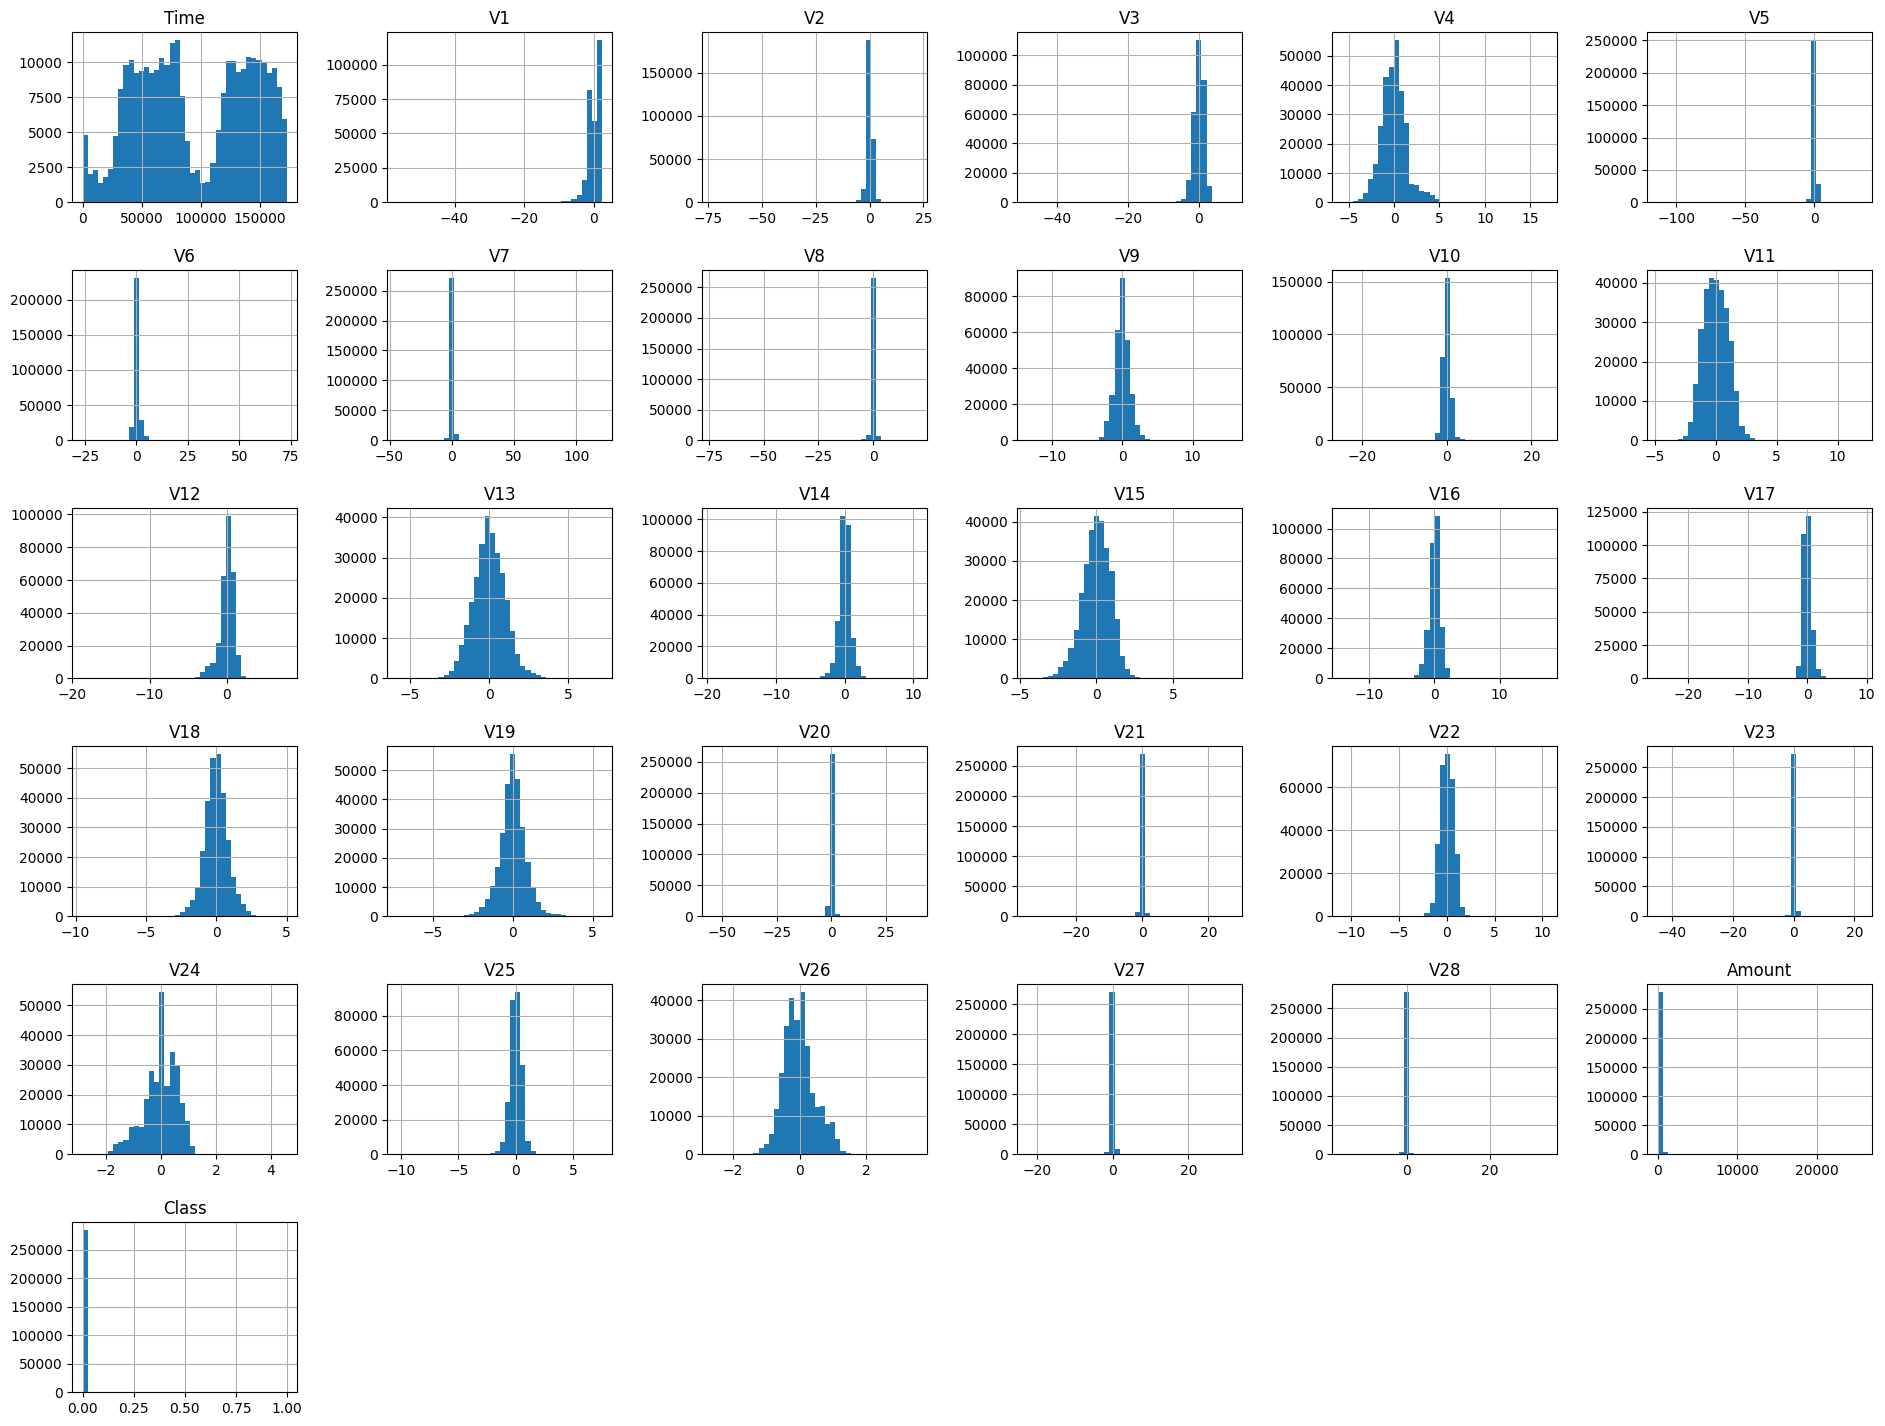

In [6]:
# Plot the histograms in a 6x6 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 16))
for i, col in enumerate(df.columns):
    ax = axes[i // 6, i % 6]
    df[col].hist(ax=ax, bins=40)
    ax.set_title(col)

# Remove the empty subplots
for i in range(len(df.columns), 36):
    axes[i // 6, i % 6].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [7]:
def class_percentage(series):
    class_counts = series.value_counts()
    return class_counts, (class_counts / class_counts.sum() * 100).round(2).astype(str).apply(lambda x: x + '%')

In [8]:
class_counts, class_percent = class_percentage(df.Class)
class_percent

0    99.83%
1     0.17%
Name: Class, dtype: object

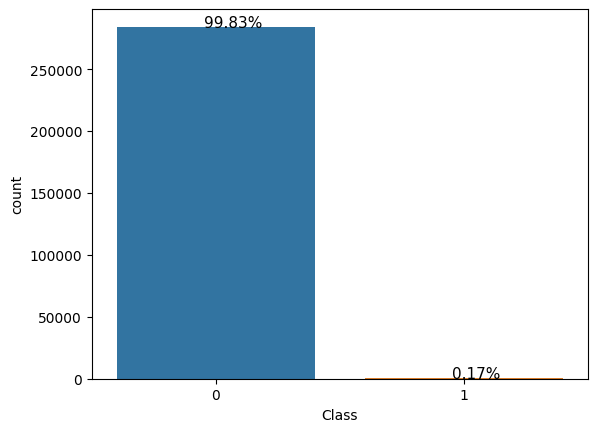

In [9]:
ax = sns.countplot(data=df, x='Class')

# Annotate the bars with their respective percentage
total = float(len(df['Class']))
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_height() + 3
    ax.text(x, y, percentage, fontsize=11)

In [10]:
# Generate a Profile Report for the dataframe
# report = ProfileReport(df)

# # Save the report to a HTML file
# report.to_file('./3. Insights and Viz/CreditCardFraud.html')


# display the report
# display(report)

Assessing the data, we noticed a few things:
- The dataset is made up of 284807 instances (rows) and 31 columns (features + target)
- The dataset has no missing data
- The dataset contians 1081 duplicated roles
- There are 31 columns, 30 of which are continuous variable (`Features`) and a descrete variable (`Target`)
- The target `Class` is binary and is highly imbalanced (99.83% No_Fraund, and 0.17% Fraud)
- Some of the independent features are peaked (high kurtosis) and skewed



Before proceeding further with any data analysis or modeling, it is crucial to split the dataset into a training set and a test set. Argueably, It is important to avoid carrying out EDA on the test set (inclusive) as this could lead to the introduction of bias during the model building phase. To prevent this, the dataset should be split into the training and test sets before any further analysis or preprocessing steps are taken.

**NOTE:** Since the testset come from the same distribution with the training set, result from our analysis carreid out on the trainset will/should be reflective of the entire dataset.

One important step that can be taken before splitting the dataset is to remove any duplicate entries - Duplicates in the dataset can affect the performance of a model by introducing bias and making it appear as if the model is more accurate than it actually is. For this reason, we will drop (remove) the duplicates in the dataset (df).

Another consideration when splitting the dataset is the imbalance nature of the data, which can introduce bias into the split. In our case, we will be using the stratified random sampling method to split the dataset by the Class (target) variable. This method ensures that the proportions of the different classes in both the training and testing sets are preserved, thus reducing the bias introduced by random sampling. let's get on with it>>

In [11]:
# drop duplicated rows in the dataframe
df = df.drop_duplicates()

# check for duplicates
df.duplicated().sum()

0

In [12]:
# randomly split the dataset into 80% train, 20% test using stratified sampling method
train, test = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=42)

# Exploratory Data Analysis

During the process of exploratory data analysis (EDA), it is common to perform various transformations on the data to gain insights and prepare the data for modeling. However, it is important to ensure that these transformations do not alter the original dataset, as this can lead to biased model performance. To avoid this issue, we will make a copy of the training set called df_explore. This copy will be used for any transformations or exploratory analysis during EDA, leaving the original training set untouched. Any changes made to df_explore will not affect the original training set and will only be used for exploratory purposes.

During the exploratory data analysis (EDA) phase, it is common to manipulate and transform the data to gain valuable insights and prepare it for modeling. However, it's essential to maintain the integrity of the original dataset to prevent introducing bias into the model's performance. To ensure this, we will create a copy of the dataset called "df_explore." This copy will serve as a dedicated dataset for all EDA-related transformations and analysis. By working with df_explore, we can freely apply various transformations and conduct exploratory analysis without affecting the original dataset. This approach safeguards the integrity of the original data while allowing us to extract meaningful insights through EDA.

In [13]:
df_explore = train.copy()

In [14]:
def plot_corr_heatmap(df=df_explore):
#   Compute correlation
    corr_matrix = df.corr()
    matrix = abs(corr_matrix).unstack()
    # matrix = matrix[matrix.between(0.4 | -0.4, 1, inclusive='neither')]
    matrix = matrix[matrix.between((0.4 or -0.4), (1 or -1), inclusive='neither')]

    
#   Create a boolean mask to hide the upper triangle of the heatmap
    mask = np.zeros_like(corr_matrix, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    
#   Set style to darkgrid
    # sns.set_style("darkgrid")

#   creates a figure and set its size
    plt.figure(figsize=(25, 15))
#   plot correlation heatmap
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)
#   render plot()
    plt.show()
    
    print(matrix)


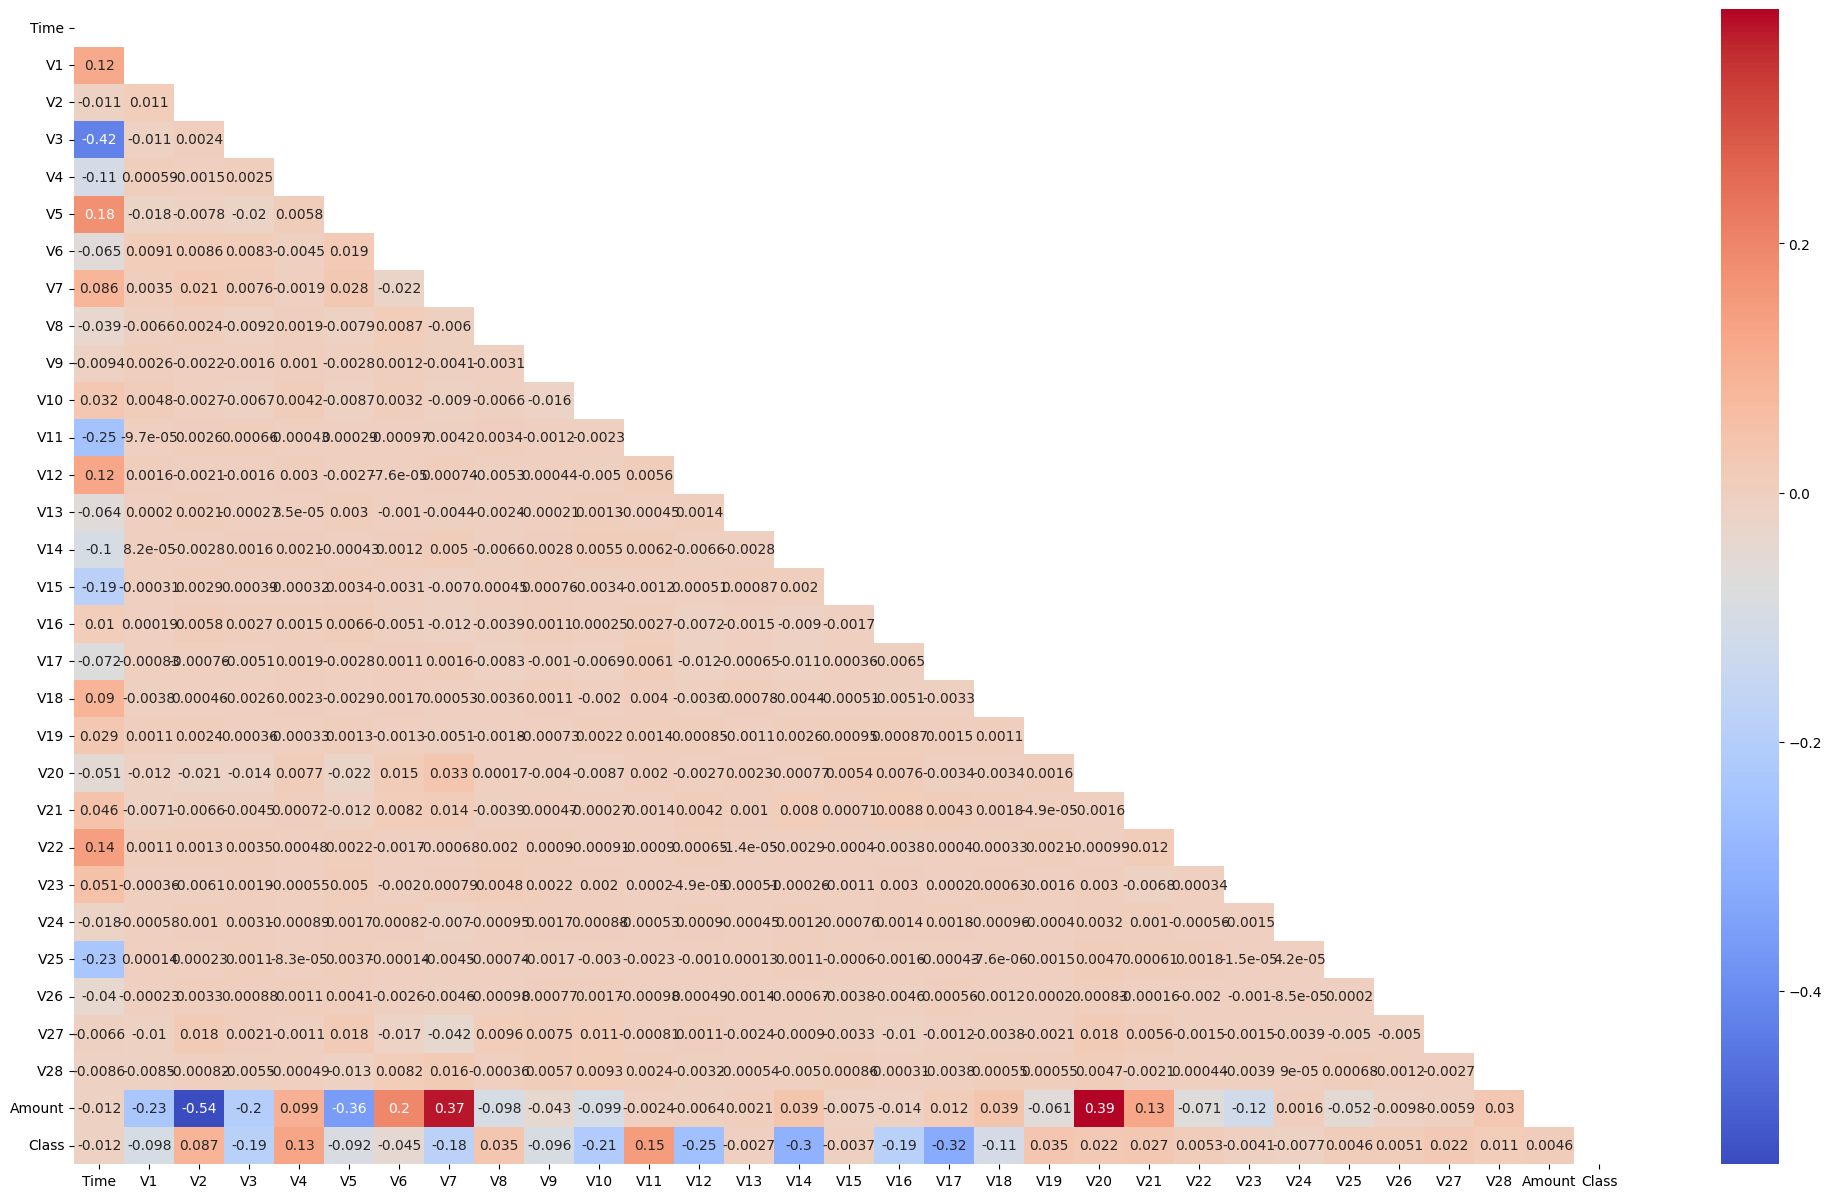

Time    V3        0.420709
V2      Amount    0.538972
V3      Time      0.420709
Amount  V2        0.538972
dtype: float64


In [15]:
plot_corr_heatmap()

from the heatmap, we can spot distinct highlight on some cells, depending on the intensity of coloration, it shows how each of the features (features and target) are correlated to each other. The standard heuristic for deciding if the correlation between two features is strong or weak is generally as follows:
- A correlation coefficient (r) between 0 and 0.3 (or -0.3) is considered weak or low.
- A correlation coefficient between 0.3 and 0.7 (or -0.3 and -0.7) is considered moderate or medium.
- A correlation coefficient greater than 0.7 (or less than -0.7) is considered strong or high.

We observe that the Time and Amount features have a moderate correlation with the V3 feature and the (V2, V7) features, respectively. This indicates that there may be some underlying relationship or pattern between these features that could potentially be useful in our modeling process. However, it is important to keep in mind that correlation does not necessarily imply causation, and further analysis is needed to establish any causal relationships between the features. 

Due to confidentiality reasons, the majority of the features in the dataset have been transformed using PCA, and this limits our ability to gain deep insights on these features. However, we still have access to the original untransformed features of Time and Amount, which provide some potential insights into the data. By focusing our exploratory analysis on these features, we might still gain a better understanding of the data and potentially uncover some interesting relationships or patterns. Additionally, by understanding the characteristics of these untransformed features, we may be able to use this information to inform the modeling process and potentially improve the accuracy of our predictions.

Before delving into the examination of the untransformed features, let's closely examine the distribution of the PCA transformed features (V1, V2, ..., V28) with respect to the non-fraud and fraud classes.

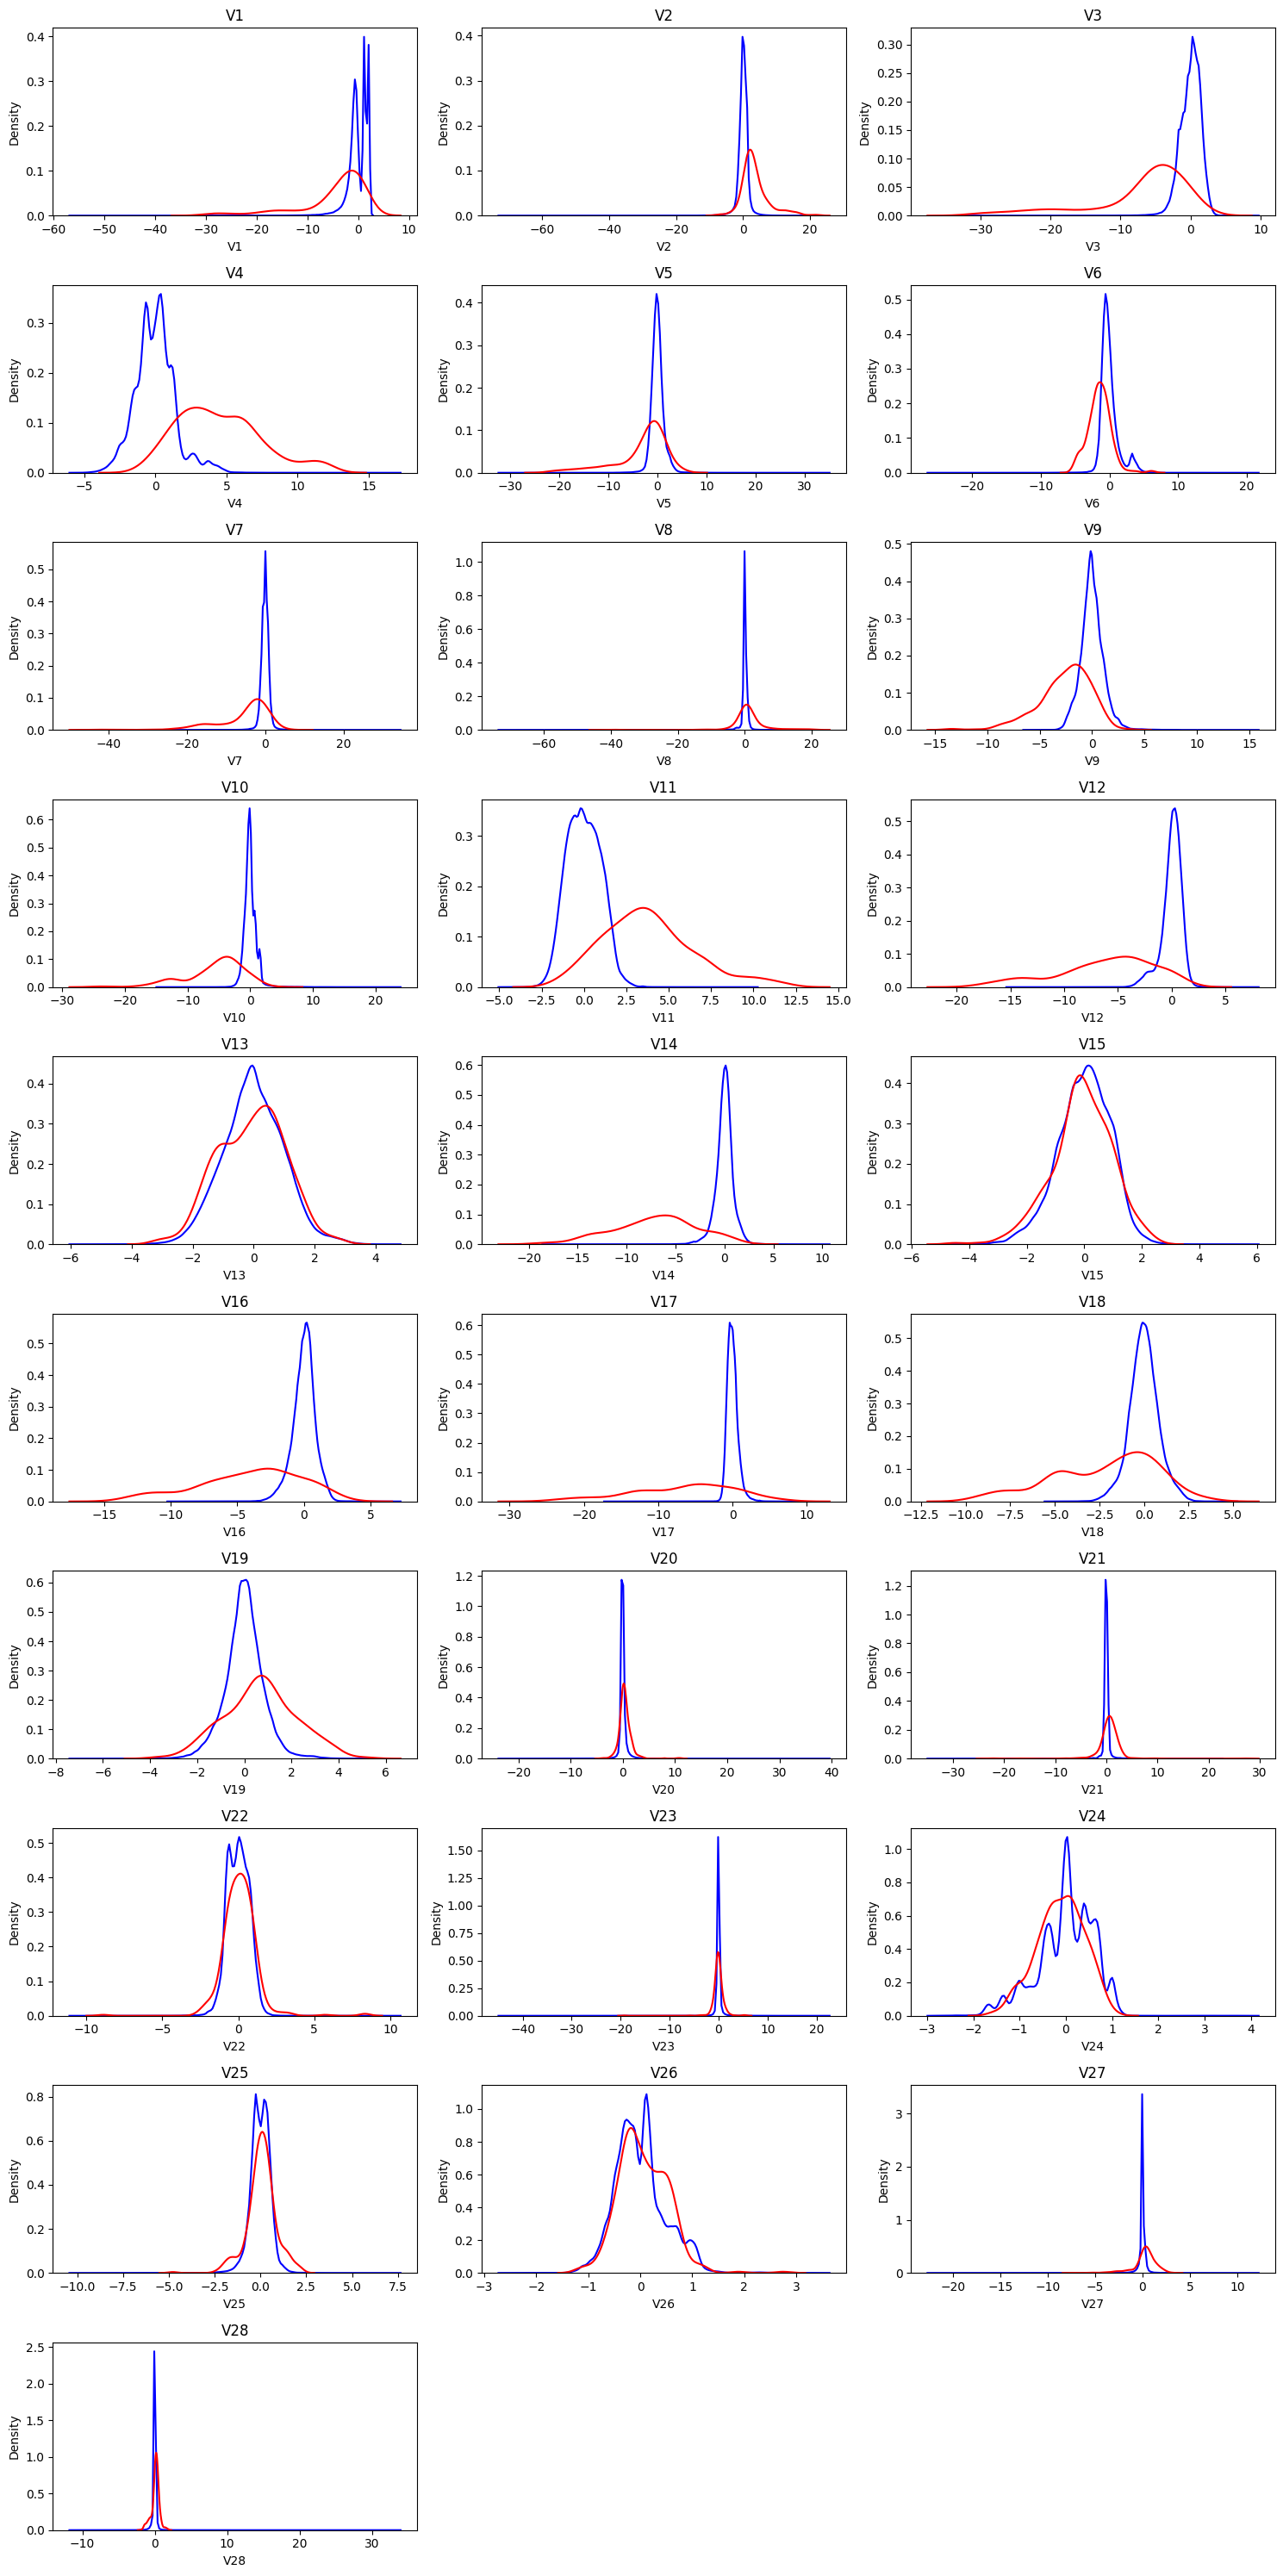

In [16]:
# Plot the histograms in a 6x6 grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 30))
for i, col in enumerate(df_explore.columns[1:-2]):
    ax = axes[i // 3, i % 3]
    sns.kdeplot(data=df_explore[df_explore['Class'] == 0], x=col, color='blue', ax=ax)
    sns.kdeplot(data=df_explore[df_explore['Class'] == 1], x=col, color='red', ax=ax)
    ax.set_title(col)

for i in range(len(df_explore.columns[1:-2]), 30):
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


In the histogram plot above, we observe the density distributions of the non-fraud and fraud classes represented by the blue and red plots, respectively. It is evident that there exist overlaps between these two classes, indicating the presence of shared data points. However, the extent of overlap varies across different features.

Upon closer examination, certain features stand out as having significantly different density distributions for each target class. These features, namely 'V1', 'V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', and 'V18' exhibit distinctive patterns that distinguish the non-fraudulent instances from the fraudulent ones.

The observed dissimilarities in the density distributions of these features highlight their potential significance in providing crucial information to a model. By selecting these features for further analysis or incorporating them into the modeling process, we can potentially enhance the model's ability to accurately classify instances, as they carry discriminative power in distinguishing between fraud and non-fraud cases.

### Time

let's start by plotting and understanding the undelying distribution

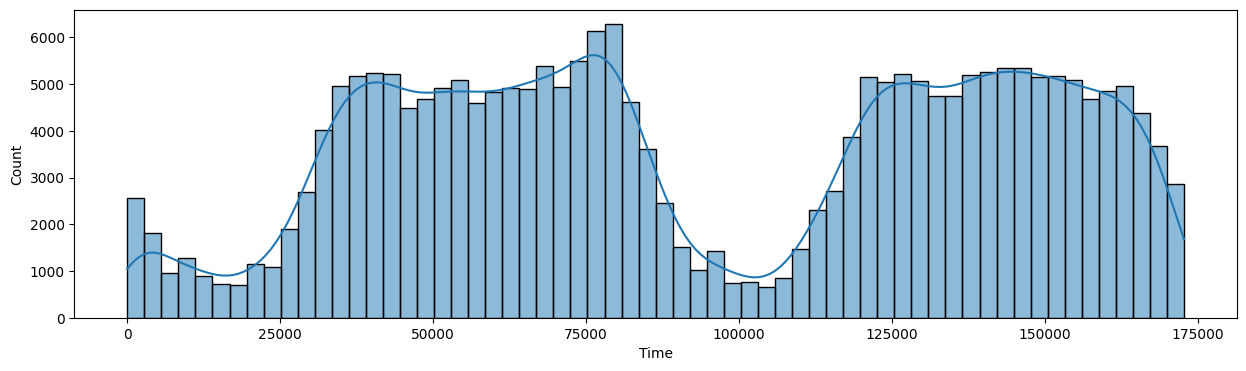

In [17]:
# plots the histogram and distribution of Time
plt.figure(figsize=(15, 4))
sns.histplot(data=df_explore, x='Time', kde=True)
plt.show()

Form the Histogram plot, we can observe that there is a bimodal distribution. One possible explanation for this bimodal distribution is that the data was collected over a two-day window time period, and there may be differences in the transaction behavior during the day versus the night.

To further investigate this pattern, we can plot the histograms of each class separately and observe any differences in the transaction behavior between the two groups.

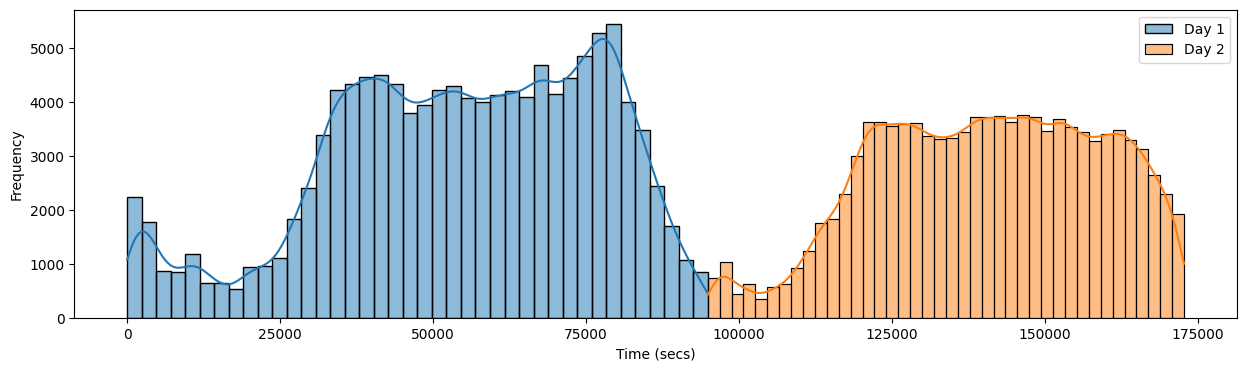

The bimodality in Time feature is significantly different between Day 1 and Day 2 with p-value: 0.0


In [18]:
# Calculate the mean and standard deviation of the Time feature
time_mean = df_explore['Time'].mean()
time_std = df_explore['Time'].std()

# Divide the data into two groups based on whether the time falls within the first 24 hours (Day 1) 
# or the second 24 hours (Day 2) of the 2-day window
day1 = df_explore[df_explore['Time'] <= time_mean]
day2 = df_explore[df_explore['Time'] > time_mean]

# Plot histograms of the two groups separately and compare the distributions visually\
plt.figure(figsize=(15, 4))
sns.histplot(day1['Time'], bins=40, alpha=0.5, kde=True, label='Day 1')
sns.histplot(day2['Time'], bins=40, alpha=0.5, kde=True, label='Day 2')
plt.xlabel('Time (secs)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Perform a statistical test to compare the two groups
stat, p = mannwhitneyu(day1['Time'], day2['Time'])
if p < 0.05:
    print('The bimodality in Time feature is significantly different between Day 1 and Day 2 with p-value:', p)
else:
    print('The bimodality in Time feature is not significantly different between Day 1 and Day 2 with p-value:', p)


The bimodality in the Time feature being significantly different between Day 1 and Day 2 validates that there are two distinct periods of time in the 2-day window with different transaction patterns, leading to two peaks in the histogram plot. However, it is important to note that since the Time feature indicates the time elapsed between the first transaction and subsequent transactions, we cannot conclude that the troughs represent nights and the peaks represent the day. This is because the time zone, location and individual transaction pattern may also contribute to the distribution of transactions. Therefore, we cannot solely rely on the Time feature to determine whether the bimodality is due to day and night patterns. However, we can conclude that the bimodality is significant and is most likely caused by the 2-day window in the data. 

Let's investigate if the time distribution differs for each class

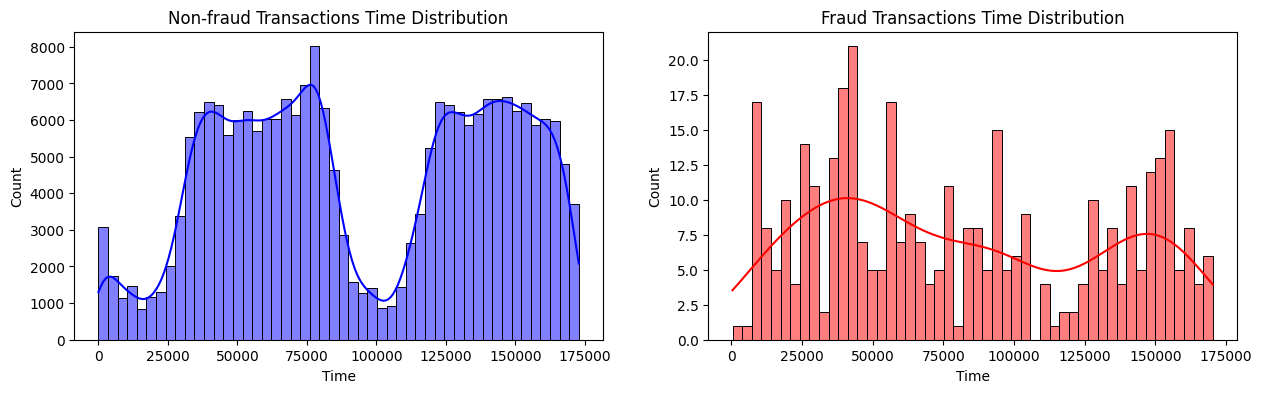

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore.Class == 0], x='Time', bins=50, kde=True, color='blue', ax=axs[0]) 
axs[0].set_title('Non-fraud Transactions Time Distribution')
sns.histplot(data=df_explore[df_explore.Class == 1], x='Time', bins=50, kde=True, color='red', ax=axs[1])
axs[1].set_title('Fraud Transactions Time Distribution')

plt.show()

The Time distribution of Fraudulent and Normal transactions provides important insights into the temporal behavior of the dataset. When we compare the non-fraud Time distribution to the overall Time distribution, we notice that they are fairly similar, suggesting that normal transactions follow a similar temporal pattern as the entire `Time` feature in the dataset. However, when we look at the Time distribution of Fraudulent transactions, we see a different pattern. This suggests that Fraudulent transactions exhibit a different temporal behavior than the normal transactions.

To gain more understanding about the distribution of Time feature, let's transform it into hours from seconds. This transformation might allow us to better visualize the temporal patterns in the data, as well as any differences between the normal and fraudulent transactions.

In [20]:
def convert_time_to_hours(df, col='Time'): 
    df_copy = df.copy()  # create a copy of the DataFrame
    df_copy[col] = (df_copy[col] // 3600) % 24
    df_copy = df_copy.rename(columns={col: 'Hours'}).astype({'Hours': int})
    return df_copy

In [21]:
df_explore = convert_time_to_hours(df_explore)

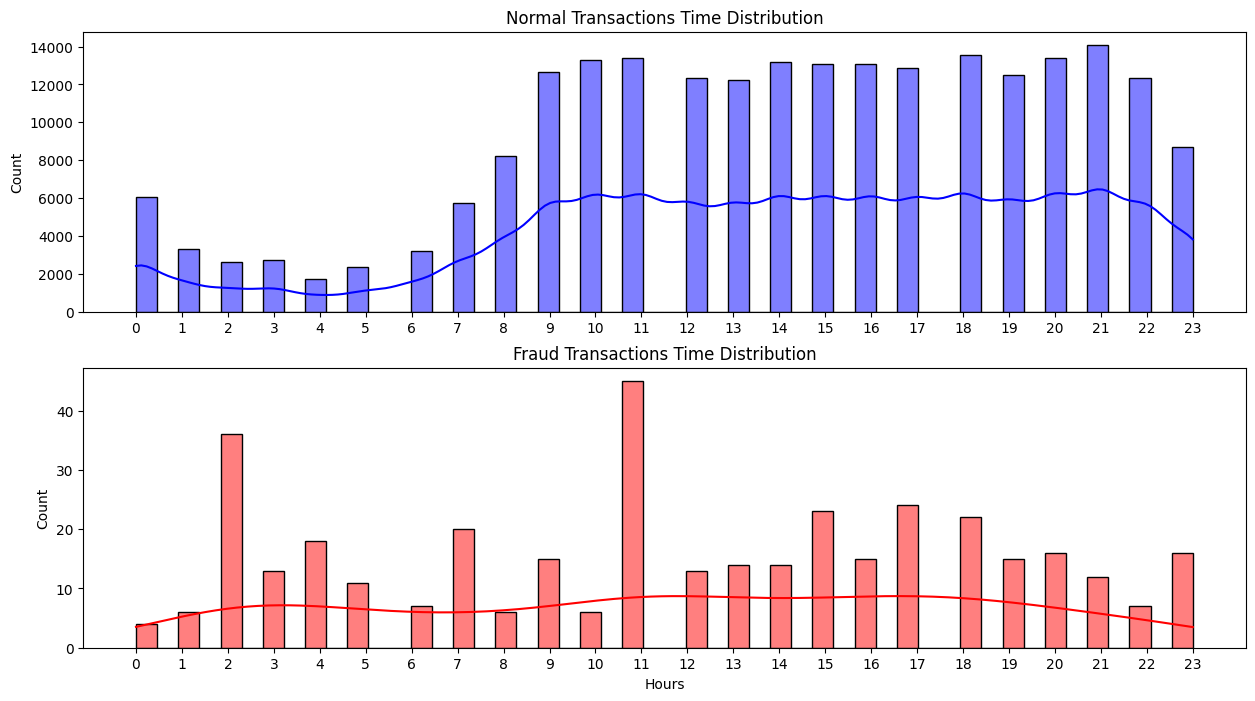

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

sns.histplot(data=df_explore[df_explore.Class == 0], x='Hours', bins=50, kde=True, color='blue', ax=axs[0]) 
axs[0].set_title('Normal Transactions Time Distribution')
axs[0].set_xticks(range(24))
axs[0].set_xlabel('')

sns.histplot(data=df_explore[df_explore.Class == 1], x='Hours', bins=50, kde=True, color='red', ax=axs[1])
axs[1].set_title('Fraud Transactions Time Distribution')
axs[1].set_xticks(range(24))

plt.show()

From the plot, we can observe that the density curve of the number of transactions starts declining from the first hour (tagged 0) and continues to decline till the fourth hour. After the fourth hour, there is a uniform increase in the number of transactions till the ninth hour, indicating that there was a period of increased transaction activity. Following this, the number of transactions remains fairly stable, with a slightly alternating constant curve, till the twentieth hour. From the twentieth hour, the curve starts to plateau, indicating a slowdown in transaction activity.
Based on this observation, it can be inferred that the normal transaction activity followed a distinct pattern, with a decline in activity in the early hours, followed by a period of increased activity from the fifth to the ninth hour, and then a relatively stable transaction activity till the twentieth hour.

In contrast to the normal transaction activity, the fraudulent density distribution showed a different pattern. The fraudulent activity curve started increasing uniformly from the zero hour and remained relatively uniform through the entire hour marks, with two significant peaks at the 2nd hour and 11th hour. This indicates that a high volume of credit card fraud occurred at these hours.

However, it is important to note that this pattern is only based on the Time feature and does not necessarily indicate a causal relationship between time of day and fraudulent activity. It is also possible that other factors such as location, type of transaction, and individual customer behavior patterns may contribute to the observed patterns. Therefore, further investigation using other features and external information is necessary to confirm whether the observed pattern is due to time-based factors or other factors which we don't have access to, unfortunately.

### Amount

let's visualize the histogram of the Amount feature in log scale

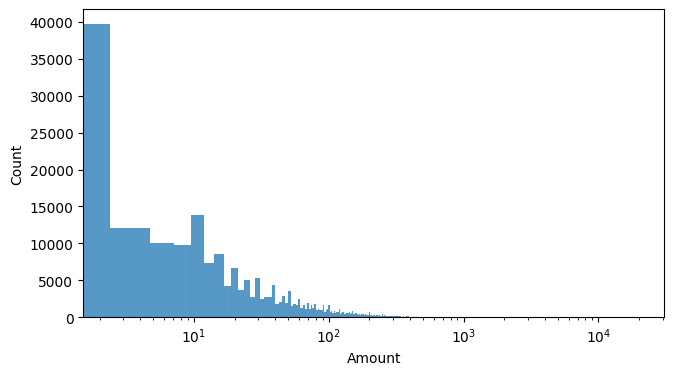

In [23]:
plt.figure(figsize=(7.5, 4))
sns.histplot(data=df_explore, x='Amount').set(xscale='log')
plt.show()

The plot shows that the distribution of the `Amount` feature is highly skewed to the right, even when we apply a logarithmic transformation. This means that the majority of the transactions have lower amounts, while a small percentage of transactions have significantly higher amounts. This could indicate that the dataset has a high number of low-value transactions and a small number of high-value transactions.

To further investigate the distribution of `Amount`, Let's plot the feature `Amount` with respect to the target `Class`. we can generate a histogram and/or density plot for each class separately. This will help us determine whether there is a difference in the distribution of `Amount` between the fraudulent and non-fraudulent (Normal) transactions; If there is a significant difference in the distribution of `Amount` between the two classes, it could indicate that the`Amount` feature is a useful predictor for detecting fraud. However, if there is no significant difference or if the distribution of Amount' is similar for both classes, then Amount' may not be a useful feature for detecting fraud. 

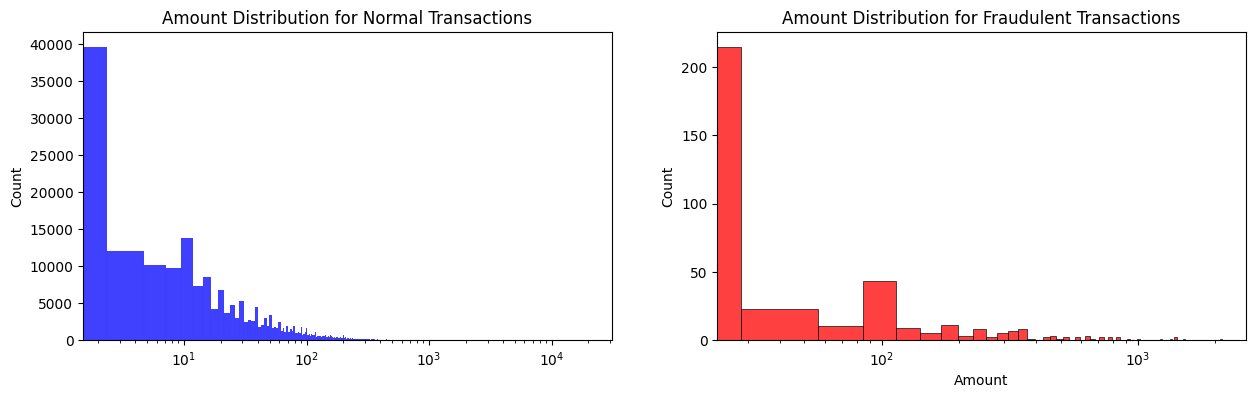

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore['Class'] == 0], x='Amount', color='blue', ax=axs[0]).set(xscale='log')
axs[0].set_title('Amount Distribution for Normal Transactions')
axs[0].set_xlabel('')
sns.histplot(data=df_explore[df_explore['Class'] == 1], x='Amount', color='red', ax=axs[1]).set(xscale='log')
axs[1].set_title('Amount Distribution for Fraudulent Transactions')
plt.show()

Interestingly, the skewness of the Amount feature is not solely due to the presence of fraudulent transactions in the dataset. In fact, the majority of the fraudulent transactions have relatively low amounts (as we can see on the right histogram plot, having its highest bar at the origin), which is counterintuitive since one might expect fraudulent transactions to have high amounts. This observation raises important questions about the characteristics of fraudulent transactions and how they differ from normal transactions. Let's investigate this a little further.


In [25]:
top_10_fraud_amounts = df_explore[df_explore['Class'] == 1]['Amount'].value_counts(ascending=False).head(10)
top_10_amounts = top_10_fraud_amounts.index.tolist()


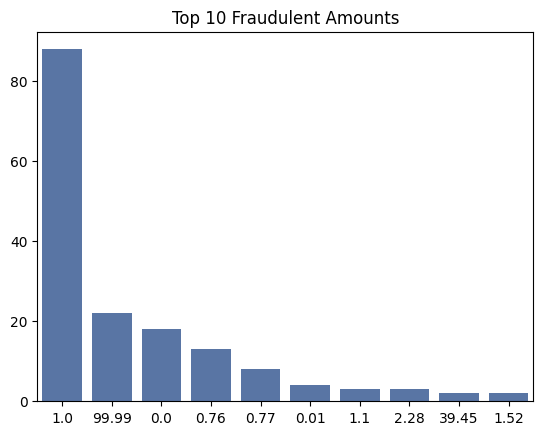

In [26]:
sns.barplot(x=top_10_fraud_amounts.index, y=top_10_fraud_amounts.values, color='#4C72B0', order=top_10_amounts)
plt.title('Top 10 Fraudulent Amounts')
plt.show()

From the barplot, we see that amount of 0.0 was considered as fraud in the dataset. The reason behind this is ambiguous, especially in the  context of this analysis. In general, it is not common for legitimate transactions to have an amount of exactly 0.0, as even small fees or taxes would result in a non-zero amount. Intuitively, we can say that an amount of 0.0 may be used as a flag for potentially fraudulent transactions or anomalies. Additionally, it is possible that some fraudsters intentionally set the amount to 0.0 in an attempt to evade detection or to test stolen credit card information before using it for larger transactions. 

Also, we see from the plot that the majority of fraudulent transactions have relatively small amounts, with the highest frequency occurring at around 1. This suggests that fraudsters tend to make small fraudulent transactions rather than large ones, which makes sense as larger transactions may be subject to more scrutiny and are more likely to trigger fraud detection systems.

To mitigate the effect of skewness on the `Amount` feature and all other features, we will be using the sklearn **PowerTransformer** feature transformation techniques. This technique can help to normalize the distribution of all the features with distributions other than Gaussian distribution.

In [27]:
# creates an instance of the PowerTransformer, using the yeo-johnson method, to mormaize the Amount
def normalizer(df, col='Amount'):
    df_copy = df.copy()
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    # fit and transform Amount features in the copy
    df_copy[col] = pt.fit_transform(df_copy[col].values.reshape(-1, 1))
    return df_copy


df_explore = normalizer(df_explore)
# view the first few rows of the transformed dataset
df_explore.head()

,Hours,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
226238,16,2.238954,-1.724499,-2.151484,-2.577803,0.993668,3.565492,-1.785957,0.860122,-1.264003,...,-0.149574,-0.049333,0.278442,0.684735,-0.219028,-0.159167,0.037920,-0.049932,0.240982,0
134253,22,-1.315062,1.630783,0.597001,-0.038359,-0.404580,-0.965712,0.212249,0.735381,-1.267926,...,-0.238898,-0.946773,0.323904,0.515632,-0.713000,-0.266503,-0.017794,0.051058,-0.632021,0
186465,11,1.908801,0.021184,-2.087997,0.129310,1.161468,0.605244,-0.022371,0.180296,0.283819,...,0.293609,1.095842,-0.044874,-1.689517,0.106098,0.007758,0.045164,-0.053068,-0.199729,0
149493,1,1.811257,0.316556,0.316751,3.880231,0.048454,1.020163,-0.734868,0.233651,0.681423,...,0.138869,0.700422,0.174064,0.702997,-0.212523,-0.010018,-0.017740,-0.038006,-0.115333,0
18461,8,1.358817,-1.120881,0.550266,-1.547659,-1.194950,0.275448,-1.201843,0.212889,-2.094285,...,-0.340972,-0.636442,0.252758,-0.344160,-0.064282,-0.439622,0.062524,0.013095,0.074352,0


In [28]:
df_explore.describe()

,Hours,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,...,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,2.269800e+05,226980.000000
mean,14.054370,0.005027,-0.005549,0.002131,-0.002025,0.004941,-0.001961,0.001480,-0.000215,-0.002883,...,0.001068,0.000073,-0.000230,0.000042,0.000247,0.000306,0.001682,0.000948,-1.714844e-16,0.001665
std,5.828895,1.947293,1.649617,1.507270,1.416960,1.359643,1.323401,1.200181,1.169342,1.094055,...,0.722252,0.724366,0.625700,0.605816,0.521633,0.481386,0.390579,0.325749,1.000002e+00,0.040775
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-32.092129,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,-2.013656e+00,0.000000
25%,10.000000,-0.915886,-0.601108,-0.887261,-0.849272,-0.689146,-0.768760,-0.552497,-0.208633,-0.644309,...,-0.228123,-0.541639,-0.162429,-0.354804,-0.317685,-0.326576,-0.070526,-0.052626,-7.452084e-01,0.000000
50%,15.000000,0.018358,0.063820,0.178307,-0.021999,-0.052477,-0.275923,0.040832,0.022232,-0.052811,...,-0.028727,0.007424,-0.011397,0.041119,0.016167,-0.051704,0.001499,0.011458,2.601354e-02,0.000000
75%,19.000000,1.315404,0.801327,1.027460,0.741399,0.615362,0.397381,0.571905,0.325467,0.594205,...,0.186916,0.528913,0.148110,0.440116,0.351206,0.240059,0.091401,0.078757,7.507558e-01,0.000000
max,23.000000,2.454930,22.057729,9.382558,16.875344,34.801666,21.393069,34.303177,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.016342,7.519589,3.517346,12.152401,33.847808,3.563974e+00,1.000000


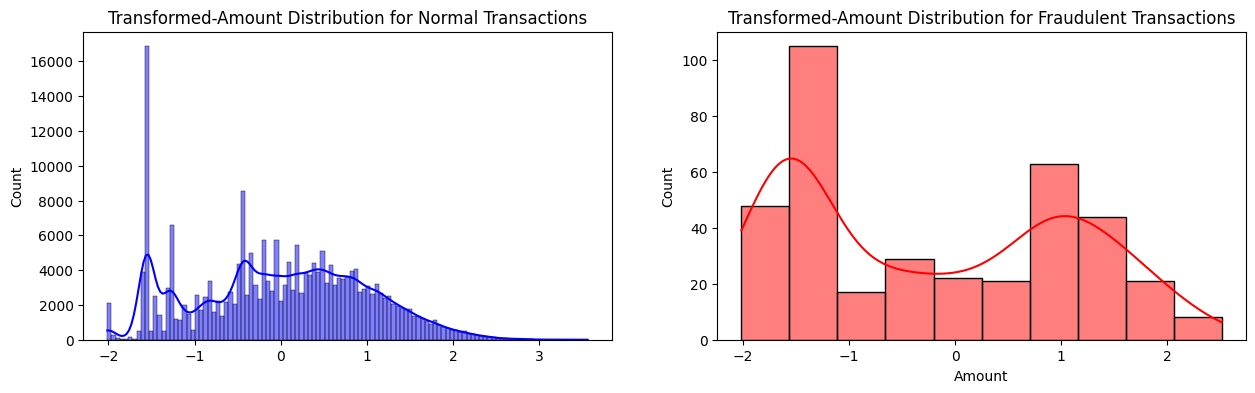

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore['Class'] == 0], kde=True, x='Amount', color='blue', ax=axs[0])
axs[0].set_title('Transformed-Amount Distribution for Normal Transactions')
axs[0].set_xlabel('')
sns.histplot(data=df_explore[df_explore['Class'] == 1], x='Amount', kde=True, color='red', ax=axs[1])
axs[1].set_title('Transformed-Amount Distribution for Fraudulent Transactions')
plt.show()

The yeo-johnson method is a powerful transformation technique used to normalize data. It is similar to the well-known Box-Cox transformation method, but unlike Box-Cox, it can handle both positive and negative values, making it a more versatile option.
When applied to the Amount feature using the sklearn PowerTransformer instance, the distribution of the Amount feature is transformed. Although the transformed curve may not be a perfect bell curve, we can observe that it bears a remarkable resemblance to the Gaussian distribution curve, which is a normal distribution curve.


### Bivariate Analysis


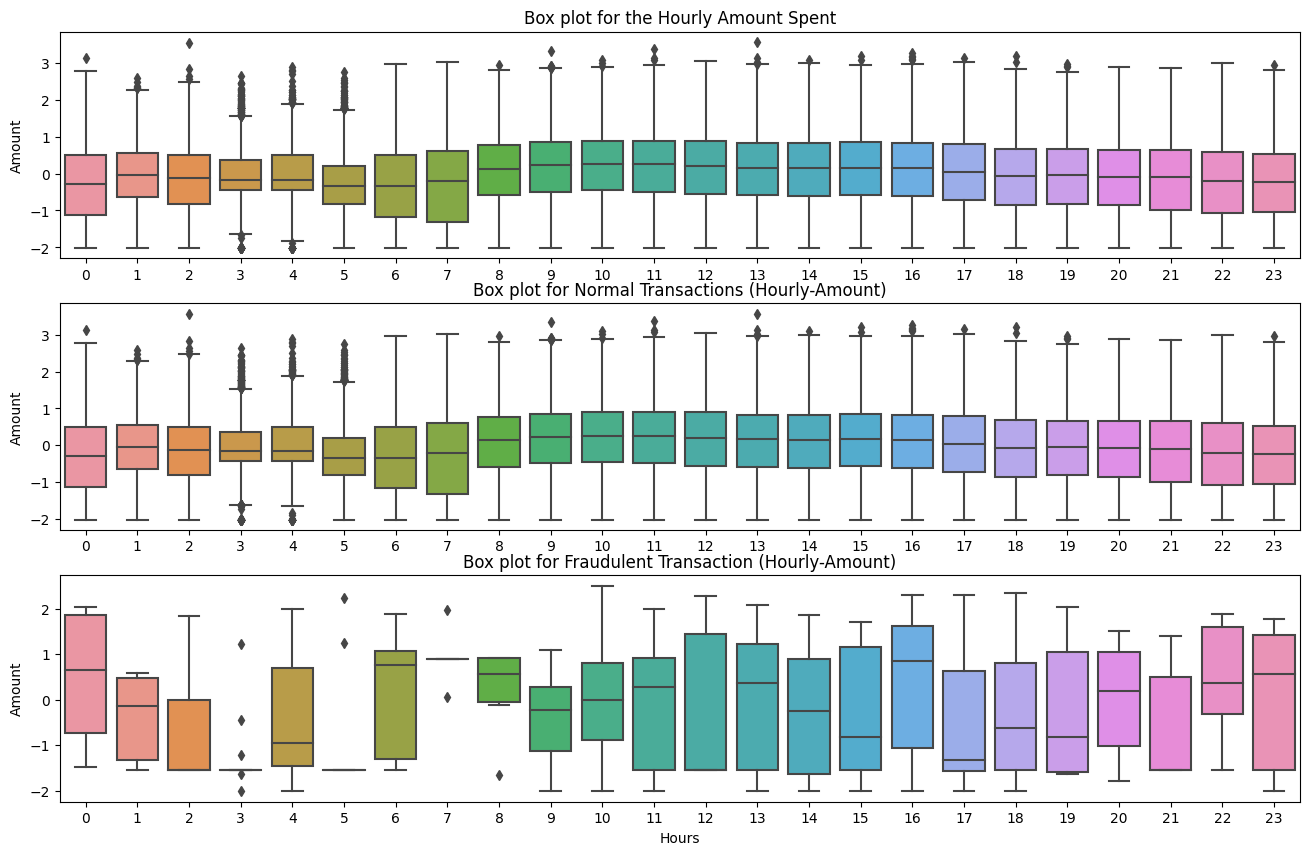

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
sns.boxplot(data=df_explore, x='Hours', y='Amount', ax=axs[0])
axs[0].set_title('Box plot for the Hourly Amount Spent')
axs[0].set_xlabel('')
sns.boxplot(data=df_explore[df_explore['Class'] == 0], x='Hours', y='Amount', ax=axs[1])
axs[1].set_title('Box plot for Normal Transactions (Hourly-Amount)')
axs[1].set_xlabel('')
sns.boxplot(data=df_explore[df_explore['Class'] == 1], x='Hours', y='Amount', ax=axs[2])
axs[2].set_title('Box plot for Fraudulent Transaction (Hourly-Amount)')

plt.show()

The boxplot analysis of the Amount feature with respect to the Time feature revealed that there are a lot of outliers spread throughout the 24 hours. However, when we examined the Amount feature more closely in relation to the Class feature, we found that while both Fraud and Normal transactions contain outliers, the number of outliers seems to be fewer in the Fraud class compared to the Normal class. This could be due to the class imbalance issue - where we have a much smaller number of Fraud observations compared to the Normal observations. This suggests that the outliers may not be indicative of fraudulent behavior. Hence, further investigation is needed to determine the reason for the presence of outliers, and whether they should be treated as genuine or erroneous observations.

To investigate the presence of outliers in the other features, we can write a function that uses the z-score to detect outliers. An observation is typically depicted as an outlier, using z-score, if it falls beyond ±3 standard deviations from the mean (i.e., z-score > 3 or z-score < -3).

In [31]:
def outliers_detection(data, threshold=3):
    
    print(f"At ±{threshold} standard deviation from the mean:")
    
    for col in data.columns[:-1]:
        var = data[col]
        z_scores = zscore(var)
        outliers = var[abs(z_scores) > threshold]
        
        if not outliers.empty:
            print(f"\t- {col} variable contains: {len(outliers)} outliers")
            if len(outliers) < 10:
                print(outliers.values)
        else:
            print(f"\t- No outliers detected for the {col} variable")


In [32]:
outliers_detection(df_explore)

At ±3 standard deviation from the mean:
	- No outliers detected for the Hours variable
	- V1 variable contains: 2911 outliers
	- V2 variable contains: 3419 outliers
	- V3 variable contains: 1549 outliers
	- V4 variable contains: 2460 outliers
	- V5 variable contains: 2398 outliers
	- V6 variable contains: 3854 outliers
	- V7 variable contains: 2851 outliers
	- V8 variable contains: 3383 outliers
	- V9 variable contains: 1807 outliers
	- V10 variable contains: 2749 outliers
	- V11 variable contains: 528 outliers
	- V12 variable contains: 2760 outliers
	- V13 variable contains: 937 outliers
	- V14 variable contains: 2692 outliers
	- V15 variable contains: 999 outliers
	- V16 variable contains: 1699 outliers
	- V17 variable contains: 2011 outliers
	- V18 variable contains: 1345 outliers
	- V19 variable contains: 2734 outliers
	- V20 variable contains: 3743 outliers
	- V21 variable contains: 3258 outliers
	- V22 variable contains: 968 outliers
	- V23 variable contains: 2631 outliers
	- V24

At this point, we have to be careful on our decision whether or not to remove the outliers because a wrong choice may either lead to loss of valuable information or add a significant bias to our model.

Dimensionality reduction techniques can help us visualize high-dimensional data in a lower-dimensional space. By reducing the dimensionality of the data, we can visualize the relationships between different features and get a better understanding of the structure of the data. The t-distributed Stochastic Neighbor Embedding (t-SNE) is one handy technique used to visualize dataset in a 2D plane. This can help us identify any patterns or clusters in the data that may not be apparent in the high-dimensional space.

Once we have a better understanding of the structure of the data, we can make a more informed decision about whether or not to remove outliers. If the outliers are part of a distinct cluster or pattern in the data, removing them may result in a loss of important information. On the other hand, if the outliers are simply noise or errors in the data, removing them may improve the performance of our model.

In [33]:
np.random.seed(42)

# Sample 5,000 non-fraud instances and all fraud instances
non_fraud_data = df_explore[df_explore['Class'] == 0].sample(5000, random_state=42)
fraud_data = df_explore[df_explore['Class'] == 1]
# Combine the subsamples into a single dataframe
subsample = pd.concat([non_fraud_data, fraud_data], axis=0)

def plot_tsne(data, subset=subsample, encoder=False, sparsity=False, encoding_units=None, random_state=42, verbose=1):
    
    X_new = data.drop(['Class'], axis=1)
    y_new = data['Class']
    # Separate the features from the target variable
    X = subset.drop(['Class'], axis=1)
    print(X.shape)
    y = subset['Class'].replace({0:'Non-fraud', 1:'Fraud'})
    
    if encoder:
        encoder_pipeline = Encoder(input_shape=X_new.shape[1], hidden_units=[64, 32], sparsity=sparsity,
                                   encoding_units=encoding_units, verbose=verbose)
        encoder_pipeline.fit(X_new, y_new)
        X = encoder_pipeline.transform(X)

        if encoder_pipeline.autoencoder is not None:
            print("Autoencoder is trained!")
            print(f'Tranformed X shape: {X.shape}')
        else:
            print("Autoencoder is not trained yet.")

    # creates a TSNE instance, fit and transfore the dataframe
    X_embedded = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=random_state).fit_transform(X)

    # Create a scatter plot of the t-SNE visualization
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='bright')

    # Add title and axis labels
    plt.title('t-SNE Visualization of Credit Card Transactions', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
 
    # Display the plot
    plt.show()

(5378, 30)


The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


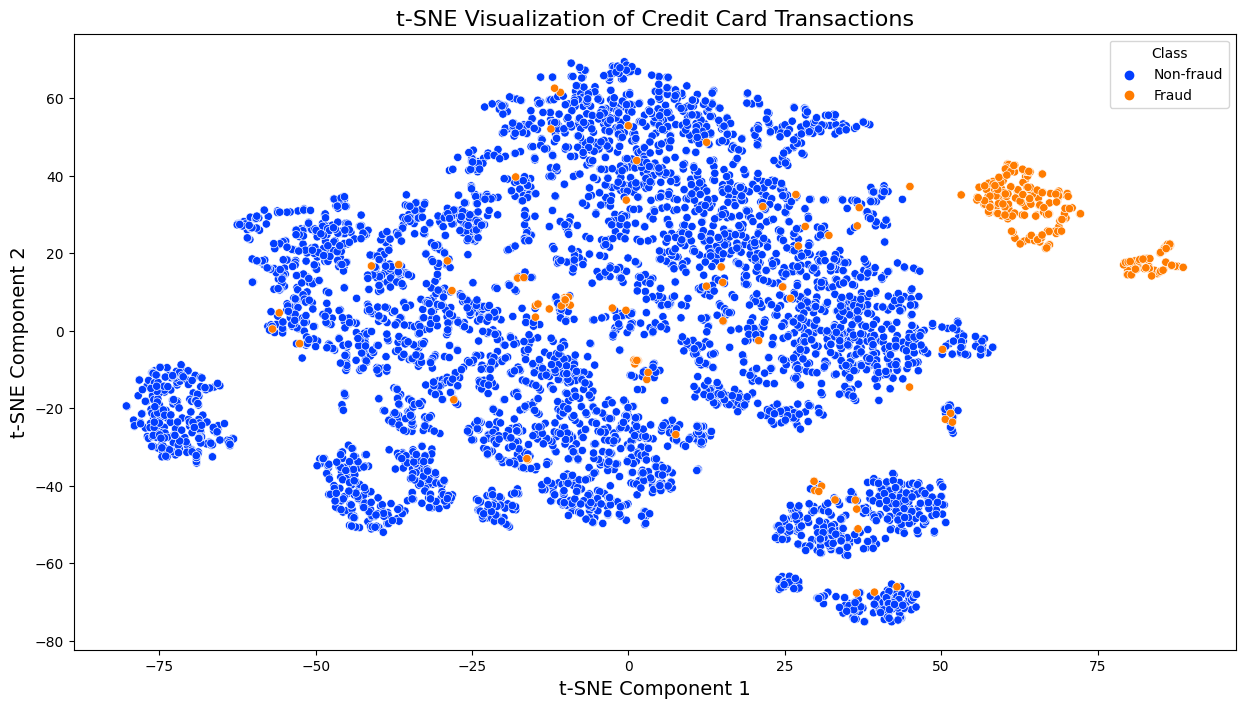

In [34]:
np.random.seed(42)

# plots the t-SNE visualization
plot_tsne(df_explore)

After collapsing the dimensions to 2D and plotting, we don't see a clear separation or distinct cluster between the non-fraud and the fraud classes. This implies that removing outliers from the dataset would result in losing valuable information. Therefore, dropping outliers is not a good approach to address class imbalance. Instead, we may need to use another approach, such as autoencoder, to learn latent representations about the dataset and reduce the dimensionality. 

And this wraps up EDA

# Modelling

## Data Preprocessing

In this section, we will be applying several pre-processing steps to our training data using a pipeline. However, before we proceed, we need to create a validation set with the same sample proportion as our test set. This step is crucial because we want our validation set to come from the same distribution as our test set and also have the same class proportion as our test set. By doing this, we can ensure that our validation set is representative of the testset data our model will be applied to. Additionally, having a validation set allows us to evaluate the performance of our model during training and make any necessary adjustments to improve its performance before applying it to the test set.

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['Class'], axis=1), train['Class'],
                                                 stratify=train['Class'], test_size=0.2, random_state=48)

### Autoencoder

What is an Autoencoder?

An autoencoder is an artificial neural network architecture that is primarily used for unsupervised learning and dimensionality reduction. It is composed of an encoder and a decoder, which work together to learn a compressed representation of the input data.
- The encoder: takes the input data and maps it to a lower-dimensional latent space representation. This latent representation contains a compressed version of the input data, capturing its most important features.
- The decoder: takes the latent representation from the encoder and reconstructs the original input data from it. The decoder's structure is symmetric to the encoder, with hidden layers gradually increasing the dimensionality of the latent representation until it matches the dimensionality of the original input.

During the training process, the autoencoder aims to minimize the reconstruction error between the input data and the output generated by the decoder. By doing so, the autoencoder learns to capture the essential features of the input data in the compressed latent space.

Autoencoders can be used for various purposes, including data compression, denoising, anomaly detection, and feature extraction. They are particularly useful for learning representations of high-dimensional data and reducing the dimensionality of input features while preserving important information.
In addition to traditional autoencoders, variations such as sparse autoencoders, variational autoencoders (VAEs), and deep autoencoders have been developed to enhance their capabilities.

Let's build and carry out unsupervised learning using traditional or sparse autoencoders in order to harness their ability to learn and condense the essential features within their latent codings. By training these autoencoder models, we aim to capture and represent the underlying patterns and structures of the input data in a compressed form. Through this process, the autoencoders can extract the most salient and discriminative features, facilitating dimensionality reduction and potentially enhancing subsequent supervised learning tasks. The sparse autoencoder, in particular, incorporates a sparsity regularization term that encourages a more sparse representation, promoting the identification of even more informative and relevant features. By leveraging these unsupervised learning techniques, we can hope to uncover hidden patterns and generate more meaningful representations, leading to improved data understanding, feature extraction, and subsequent analysis and decision-making processes.


In [36]:
class CustomKLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        super().__init__()
        self.weight = weight
        self.target = target
        self.kl_divergence = KLDivergence()

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        kl_div = self.kl_divergence(self.target, mean_activities) + self.kl_divergence(1. - self.target, 1. - mean_activities)
        return self.weight * kl_div


In [37]:
class Autoencoder(tf.keras.Model):
    def __init__(self, input_shape, hidden_units=[], sparsity=False, 
                 div_weight=5e-4, kld_target=.1, regularizer_strength=1e-5, encoding_units=23):
        super(Autoencoder, self).__init__()

        # Define KL divergence regularizer
        self.kl_divergence_weight = div_weight
        self.sparsity_factor = kld_target

        if sparsity:
            kld_regularizer = CustomKLDivergenceRegularizer(weight=self.kl_divergence_weight, target=self.sparsity_factor)

            self.encoder = Sequential([Dense(units, activation='relu', 
                                             activity_regularizer=l1(10e-5)) for units in hidden_units] + 
                           [Dense(encoding_units, activation='relu', activity_regularizer=kld_regularizer)])

        else:
            self.encoder = Sequential([Dense(units, activation='relu') for units in hidden_units] + 
                                      [Dense(encoding_units, activation='relu')])

        # Tie the weights of the decoder to the encoder
        self.decoder = Sequential([Dense(units, activation='relu') for units in reversed(hidden_units)] +
                                  [Dense(input_shape)]) 
        
    def call(self, inputs):
        # Encoder output
        encoded = self.encoder(inputs)

        # Decoder output
        decoded = self.decoder(encoded)

        return decoded

In [38]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_shape, hidden_units=[], sparsity=False, 
                 div_weight=5e-4, kld_target=.2, encoding_units=23, verbose=0):
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        self.sparsity = sparsity
        self.div_weight = div_weight
        self.kld_target = kld_target
        self.encoding_units = encoding_units
        self.verbose = verbose
        self.autoencoder = None
    

    def fit(self, X, y=None):

        self.autoencoder = Autoencoder(input_shape=self.input_shape, 
                                       hidden_units=self.hidden_units,
                                       sparsity=self.sparsity,
                                       div_weight=self.div_weight,
                                       kld_target=self.kld_target,
                                       encoding_units=self.encoding_units)
        
        self.autoencoder.compile(optimizer='adam', loss='mse')
        
        neg_idx = np.where(y == 0)[0]
        X_filtered = np.take(X, neg_idx, axis=0)
        
        self.autoencoder.fit(X_filtered, X_filtered, epochs=15, batch_size=256, validation_split=0.2, verbose=self.verbose)
        return self
    
    def transform(self, X):
        encoded_data = self.autoencoder.encoder.predict(X)
        reconstructed_data = self.autoencoder.predict(X)
        # Calculate the reconstruction error
        reconstruction_error = np.mean(np.square(X - reconstructed_data), axis=1)
        return encoded_data


Let's train the autoencoder on the non-fraud class data, leveraging its ability to learn meaningful representations; use the codings obtained from the trained autoencoder to transform both non-fraud and fraud subsamples drawn from the df_explore dataset; and visualize the latent encoding layers in a 2D plane to gain insights into the data distribution and potential clusters. To accomplish this, we will call the plot_tsne function we created, passing the appropriate keyword arguments to ensure the correct visualization.

(5378, 30)
Epoch 1/15
709/709 [==============================] - 2s 2ms/step - loss: 0.8192 - val_loss: 0.2389
Epoch 2/15
709/709 [==============================] - 1s 2ms/step - loss: 0.1659 - val_loss: 0.1264
Epoch 3/15
709/709 [==============================] - 1s 2ms/step - loss: 0.1002 - val_loss: 0.0842
Epoch 4/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0714 - val_loss: 0.0639
Epoch 5/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0569 - val_loss: 0.0517
Epoch 6/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0486 - val_loss: 0.0465
Epoch 7/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0432 - val_loss: 0.0453
Epoch 8/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0372
Epoch 9/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0343 - val_loss: 0.0340
Epoch 10/15
709/709 [==============================] - 1s 2ms/step - loss: 0.0310 - val_l

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


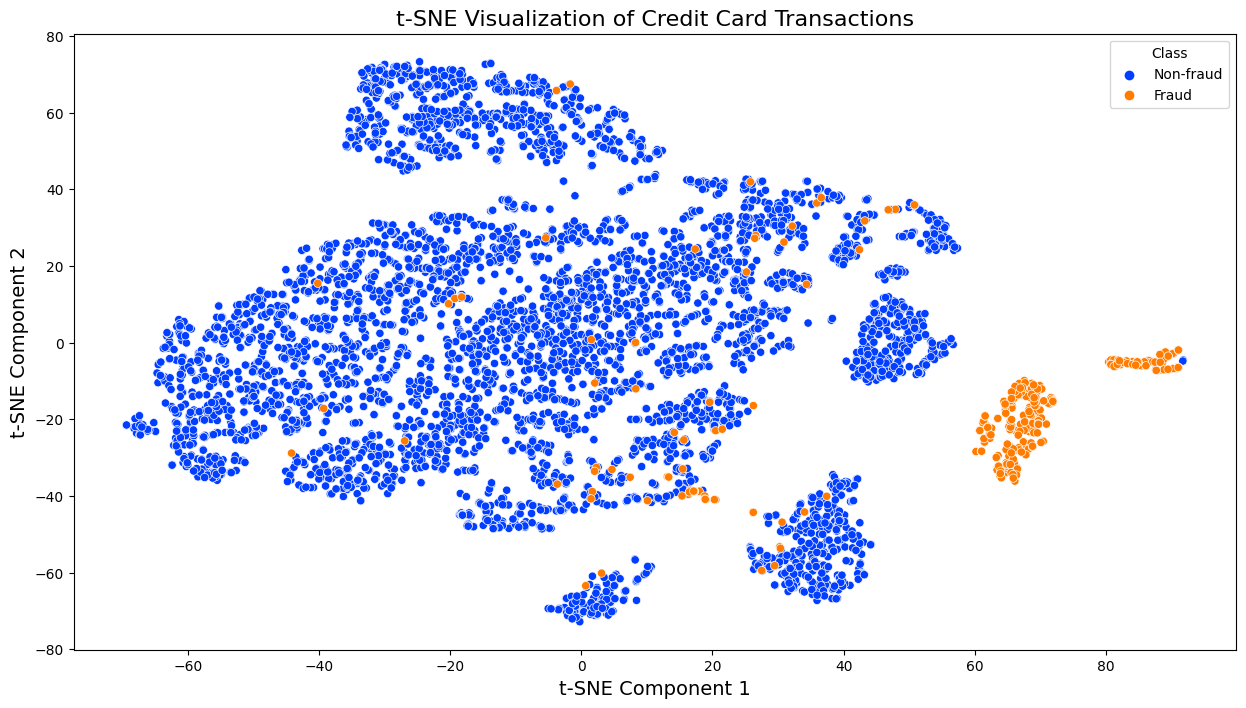

In [39]:
np.random.seed(42)
# plots the t-SNE visualization on the encoded generaters 5000 samples
plot_tsne(df_explore, encoder=True, encoding_units=22, sparsity=True, random_state=42)

The compressed t-SNE plot highlights the effectiveness of the autoencoder in capturing and preserving the underlying patterns and structure of the dataset. Through dimensionality reduction and potential noise removal, the fraud datapoints exhibit a higher level of concentration in the compressed plot, contrasting with their dispersed arrangement, especially in the region of overlap, in the uncompressed t-SNE plot. This enhanced compactness and separation among the fraud samples signify the autoencoder's ability to extract meaningful features that discriminate between fraud and non-fraud instances. By leveraging these improved representations, we can potentially develop more accurate and robust fraud detection models and strategies that capitalize on the refined understanding of the data.

### Model Training

In [40]:
def create_pipeline(input_shape=None, over=False, over_sampling=SMOTE(random_state=42), under=False, autoencoder=False, k='all',
                    undersampling=RandomUnderSampler(random_state=42), hidden_units=[64], encoding_units=23, sparsity=False, selector=False):
    
    # create a transformer for categorical features
    def hour_cat_pipeline():
        return Pipeline([('hour_converter', FunctionTransformer(func=convert_time_to_hours))])
    
    amt_transformed =  Pipeline([('amt_normaalized', PowerTransformer())])
    
    # creates a numerical transformer pipeline
    default_pipeline = Pipeline(steps=[('normalizer', Normalizer())])

    # Combine the transformers with the ColumnTransformer
    transformers = [('time', hour_cat_pipeline(), ['Time']),
                    ('amt_norm', amt_transformed, ['Amount'])]

    preprocessor = ColumnTransformer(transformers=transformers, remainder=default_pipeline)

    pipeline_steps = [('preprocessor', preprocessor)]

    if autoencoder:
        pipeline_steps.append(('encode', Encoder(input_shape, hidden_units=hidden_units, sparsity=sparsity, 
                                                 encoding_units=encoding_units)))
    if over:
        pipeline_steps.append(('sampling', over_sampling))
    if under:
        pipeline_steps.append(('under_sampling', undersampling))
    if selector:
        pipeline_steps.append(('feature_selector', SelectKBest(score_func=mutual_info_classif, k=k)))
        
    return pipeline_steps

In [41]:
def get_clf_report(y_val, y_preds, labels):
    clf_report = classification_report(y_val, y_preds, target_names=labels, output_dict=True)
    report = classification_report(y_val, y_preds, target_names=labels)
    auc_report = round(roc_auc_score(y_val, y_preds), 2)
   
    return report, clf_report, auc_report



def plot_confusion_matrix(y_val, y_preds, labels, clf_name):
     # Create confusion matrix
    cm = confusion_matrix(y_val, y_preds)

    # Create ConfusionMatrixDisplay object
    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(4, 3))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title(f'Error Analysis (Comfusion Matrix): {clf_name}')
    plt.xticks(rotation=0)
    plt.show()
    
    

def find_best_threshold(y_true, y_pred_probs):
    thresholds = np.arange(0.1, 1.0, 0.1) 
    best_threshold = 0.5  # Initial best threshold
    best_f1 = 0.0  # Initial best F1 score

    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
        f1 = f1_score(y_true, y_pred)  # Compute F1 score

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


In [42]:
def train_evaluate(clfs=None, labels=None, cm=False, over=False, weight=False, class_report=False, eval_set=True, k='all',
                   over_sampling=SMOTE(), under=False, undersampling=RandomUnderSampler(), selector=False, thresh=False,
                   autoencoder=False, hidden_units=[64,32], encoding_units=21, sparsity=False, input_shape=X_train.shape[1]):

    # creates an empty dataframe with the metrics of interest as the column names
    results_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'F1-score', 'AUC_ROC', 'Support'])

    if clfs is not None:
        for name, classifier in clfs.items():

            pipeline_steps = create_pipeline(input_shape=input_shape,
                                             over=over,
                                             over_sampling=over_sampling,
                                             autoencoder=autoencoder,
                                             under=under,
                                             undersampling=undersampling,
                                             selector=selector, k=k,
                                             hidden_units=hidden_units,
                                             encoding_units=encoding_units,
                                             sparsity=sparsity)

            clf_name = str(name)
            pipeline_steps.append((clf_name, classifier))

            # make pipeline
            pipeline = imbPipeline(steps=pipeline_steps)

            if weight:
                if over or under:
                    if not selector:
                        # Fit the pipeline up to the resampling steps
                        X_train_resampled, y_train_resampled = pipeline[:-1].fit_resample(X_train, y_train)
                    else:
                        X_train_resampled, y_train_resampled = pipeline[:-2].fit_resample(X_train, y_train)
                        
                    # Compute class weights based on the resampled data
                    class_weights = compute_class_weight(class_weight='balanced', 
                                                     classes=np.unique(y_train_resampled), y=y_train_resampled)
                else:
                    # Compute class weights based on the resampled data
                    class_weights = compute_class_weight(class_weight='balanced', 
                                                     classes=np.unique(y_train), y=y_train)

                # Convert class_weights to a dictionary
                class_weights_dict = {i: w for i, w in enumerate(class_weights)}

                # Adjust the class weights in the classifier step of the pipeline
                pipeline[clf_name].class_weight = class_weights_dict


            # Fit the pipeline to the original data
            pipeline.fit(X_train, y_train)

            if eval_set:
                if thresh:
                    y_pred_probs = pipeline.predict_proba(X_val)[:, 1]  # Get predicted probabilities for positive class
                    best_threshold, best_f1 = find_best_threshold(y_val, y_pred_probs)  # Find best threshold using previous code
                    y_preds = (y_pred_probs >= best_threshold).astype(int)  # Apply best threshold to get binary predictions
                else:
                    y_preds = pipeline.predict(X_val)
                    
                # Evaluate model
                report, clf_report, auc_report = get_clf_report(y_val, y_preds, labels)

                if class_report:
                    print(f'Classifier name: {clf_name} \nROC_AUC score: {round(auc_report, 2)}\n\n', report, '\n\n')

                if cm:
                    plot_confusion_matrix(y_val, y_preds, labels, clf_name)
                    print('\n\n')

            else:
                print('Set eval_set keyword argument to True to evaluate the performance of the model')

            # Extract macro average from classification report
            macro_report = {
                'precision': round(clf_report['macro avg']['precision'], 2),
                'recall': round(clf_report['macro avg']['recall'], 2),
                'f1-score': round(clf_report['macro avg']['f1-score'], 2),
                'support': round(clf_report['macro avg']['support'], 2)
            }

            # Add AUC-ROC score to dataframe
            clf_report['auc-roc'] = {'precision': np.nan, 'recall': np.nan, 'f1-score': np.nan, 'support': np.nan,
                                     '': auc_report}

            # Append dataframe to results dataframe
            results_df = pd.concat([results_df, pd.DataFrame({'Classifier': [clf_name],
                                                  'Precision': [macro_report['precision']],
                                                  'Recall': [macro_report['recall']],
                                                  'F1-score': [macro_report['f1-score']],
                                                  'AUC_ROC': [auc_report],
                                                  'Support': [macro_report['support']]})], axis=0, ignore_index=True)
    else:
        print('Provide a dictionary of valid classifier(s)')
    
    if not thresh:
        return pipeline, results_df
    else:
        return pipeline, best_threshold, results_df

In [43]:
classifiers = {'RandomForestClassifier': RandomForestClassifier(),
               'LogisticRegression': LogisticRegression(max_iter=1000),
               'XGBClassifier':XGBClassifier(), 
               'LGBMClassifier':LGBMClassifier()}

labels = ['Non Fraud', 'Fraud']

In [44]:
_, table_0 = train_evaluate(classifiers, labels=labels)
print('Macro Average Classification Report for the Default Classifiers')
table_0

Macro Average Classification Report for the Default Classifiers


,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.95,0.86,0.90,0.86,45396
1,LogisticRegression,0.92,0.85,0.88,0.85,45396
2,XGBClassifier,0.96,0.87,0.91,0.87,45396
3,LGBMClassifier,0.60,0.79,0.65,0.79,45396


In [45]:
_, table_1 = train_evaluate(classifiers, weight=True, labels=labels)
print('Cost-Sensitive Classification Report (Macro Average) for the Default Classifiers')
table_1

Cost-Sensitive Classification Report (Macro Average) for the Default Classifiers


,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.98,0.87,0.92,0.87,45396
1,LogisticRegression,0.52,0.92,0.53,0.92,45396
2,XGBClassifier,0.96,0.87,0.91,0.87,45396
3,LGBMClassifier,0.94,0.88,0.91,0.88,45396


In [46]:
_, table_2 = train_evaluate(classifiers, autoencoder=True, encoding_units=22, sparsity=True, weight=True, labels=labels)
print('Cost-Sensitive Classification Report (Macro Average) for the Default Classifiers')
table_2

Cost-Sensitive Classification Report (Macro Average) for the Default Classifiers


,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,1.00,0.67,0.75,0.67,45396
1,LogisticRegression,0.51,0.90,0.50,0.90,45396
2,XGBClassifier,0.97,0.70,0.78,0.70,45396
3,LGBMClassifier,0.70,0.87,0.76,0.87,45396


In [47]:
_, table_3 = train_evaluate(classifiers, over=True, labels=labels)
print('Macro Average Classification Report for Default Classifiers with Resampling: SMOTE')
table_3

Macro Average Classification Report for Default Classifiers with Resampling: SMOTE


,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.93,0.90,0.91,0.90,45396
1,LogisticRegression,0.50,0.88,0.47,0.88,45396
2,XGBClassifier,0.90,0.91,0.91,0.91,45396
3,LGBMClassifier,0.50,0.75,0.42,0.75,45396


In [48]:
_, table_4 = train_evaluate(classifiers, autoencoder=True, over=True, encoding_units=22, sparsity=True, labels=labels)
print('Macro Average Classification Report for Default Classifiers with Resampling: SMOTE')
table_4

Macro Average Classification Report for Default Classifiers with Resampling: SMOTE


,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.84,0.76,0.80,0.76,45396
1,LogisticRegression,0.50,0.73,0.32,0.73,45396
2,XGBClassifier,0.72,0.87,0.78,0.87,45396
3,LGBMClassifier,0.50,0.71,0.40,0.71,45396


In [49]:
column_titles  = ['Autoencoder: False', 'Autoencoder: True']
table_titles = ['Table 1: Class weight=True', 'Table 2 Class weight=True', 'Table 3: SMOTE=True', 'Table 4: SMOTE=True']

# Create a 2x2 grid layout
html = '<table style="width:100%">'

# Add column titles
html += '<tr>'
for title in column_titles:
    html += f'<th style="text-align:center; font-size:20px;">{title}</th>'
html += '</tr>'

# Iterate over the DataFrames and generate HTML for each table
dataframes = [table_1, table_2, table_3, table_4]

for i, (df, table_title) in enumerate(zip(dataframes, table_titles)):
    # Add a new table row for each DataFrame
    if i % 2 == 0:
        html += '<tr>'
    
    # Convert DataFrame to HTML table representation with title
    html += f'<td valign="top"><h2 style="text-align:left;">{table_title}</h2>{df.to_html()}</td>'
    
    # Close the table row if it's the end of a column
    if (i + 1) % 2 == 0:
        html += '</tr>'

# Close the HTML tags
html += '</table>'

# Display the HTML
display(HTML(html))


Upon comparing the tables, it is evident that our initial expectation of improving performance by compressing the dimensions was not met. Surprisingly, this preprocessing step actually had a negative impact on the models' performance, as compared to only using resampling techniques. As a result, moving forward, we would disable the autoencoder preprocessing step and focus solely on the resampling and/or cost-sensitive learning techniques in our experiments. We will explore other techniques specifically targeted at improving the model's performance while omitting the autoencoder step from the pipeline.

## Hyperparameter Tuning

In [50]:
# best_params = {}

# classifiers = {'RandomForestClassifier': RandomForestClassifier,
#                'XGBClassifier': XGBClassifier,
#                'LogisticRegression': LogisticRegression,
#                'LGBMClassifier': LGBMClassifier}

# # define Optuna search space function
# def objective(trial, clf_name, classifier):
#     # Define the hyperparameters to search
#     k_neighbors = trial.suggest_int('k_neighbors', 4, 12)
    
    
#     if clf_name == 'LGBMClassifier':
#         params = {'objective': 'binary',
#                                 'n_estimators': trial.suggest_int('n_estimators', 50, 500, log=True),
#                                 'num_leaves': trial.suggest_int('num_leaves', 2, 50),
#                                 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
#                                 'max_depth': trial.suggest_int('max_depth', 4, 19),
#                                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1, log=True),
#                                 'min_split_gain': trial.suggest_float('min_split_gain', 1e-5, 1, log=True),
#                                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-05, 1, log=True),
#                                 'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1, log=True)}
        
#     elif clf_name == 'LogisticRegression':
#         params = {'solver': trial.suggest_categorical('solver', ['lbfgs', 'sag']),
#                   'penalty':  trial.suggest_categorical('penalty', ['l2', 'none']),
#                   'C': trial.suggest_float('C', 1e-4, 14, log=True),
#                   'max_iter': trial.suggest_categorical('max_iter', [1000])}
              
#     elif clf_name == 'RandomForestClassifier':
#         params = {'n_estimators': trial.suggest_int('n_estimators', 50, 500, log=True),
#                   'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#                   'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#                   'max_depth': trial.suggest_int('max_depth', 8, 20),
#                   'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                   'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10)}
        
#     elif clf_name == 'XGBClassifier':
#         params = {
#         'objective': 'binary:logistic',
#         'booster': 'gbtree',
#         'n_estimators': trial.suggest_int('n_estimators', 50, 600, log=True),
# #         'tree_method': 'gpu_hist',  # Enable GPU support
# #         'gpu_id': 0  # Enable GPU prediction
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
#         'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
#         'max_depth': trial.suggest_int('max_depth', 6, 18),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
#         'gamma': trial.suggest_float('gamma', 0.01, 1.0),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True)}


#     # create an instance of the classifier with it defined hyperparameters to search
#     model = classifier(**params)

#     # create the pipeline steps
#     pipeline_steps = create_pipeline(over=True, over_sampling=SMOTE(k_neighbors=k_neighbors, random_state=42))
    
#     # Add classifier to the pipeline
#     pipeline_steps.append((str(clf_name), model))
#     # compile pipeline steps
#     pipeline = imbPipeline(steps=pipeline_steps)

#     # Use cross-validation to train and evaluate the model's performance
#     pipeline.fit(X_train, y_train)
    
#     y_preds = pipeline.predict(X_val)
    
#     score = f1_score(y_preds, y_val, average='macro')

#     # Report intermediate objective value
#     trial.report(score, step=trial.number)

#     # Prune the trial if necessary
#     if trial.should_prune():
#         raise optuna.TrialPruned()

#     return score

# # Set up SkoptSampler and HyperbandPruner
# sampler = optuna.samplers.TPESampler(multivariate=True)
# pruner = optuna.pruners.HyperbandPruner(min_resource=3, reduction_factor=6)

# # Iterate through classifiers and find the best hyperparameters for each
# for clf_name, classifier in classifiers.items():
#     study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
#     study.optimize(lambda trial: objective(trial, clf_name, classifier), n_trials=70, n_jobs=5)
    
#     # Store the best hyperparameters for this classifier
#     best_params[clf_name] = study.best_params

# print('Best parameters:')
# for clf_name, params in best_params.items():
#     print(f'{clf_name}: {params}')

In [51]:
best_params = {
    'RandomForestClassifier': {'n_estimators': 287,
                               'criterion': 'entropy', 
                               'max_features': 'log2', 
                               'max_depth': 20, 
                               'min_samples_split': 6,
                               'min_samples_leaf': 4},
    
    'XGBClassifier': {'n_estimators': 246,
                      'learning_rate': 0.6705573044054888,
                      'eta': 0.28338761370648413, 
                      'max_depth': 17, 
                      'subsample': 0.9303176844939145,
                      'colsample_bytree': 0.6683927598822134, 
                      'gamma': 0.3011962577652987, 
                      'min_child_weight': 2.0781997229072635, 
                      'reg_alpha': 0.00048315180144797105, 
                      'reg_lambda': 0.8682386575178049},
    
    'LogisticRegression': {'solver': 'sag',
                            'penalty': 'l2',
                            'C': 0.00010890212387466569,
                            'max_iter': 1000},
    
    'LGBMClassifier': {'n_estimators': 450,
                       'num_leaves': 49,
                       'learning_rate': 0.06333777936683095,
                       'max_depth': 15,
                       'subsample': 0.8432753202271054,
                       'colsample_bytree': 0.8720210070371737,
                       'min_split_gain': 1.3310474141375757e-05,
                       'reg_alpha': 1.1277232459250383e-05,
                       'reg_lambda': 0.0011060041380002179}}

In [52]:
classifiers = {'RandomForestClassifier': RandomForestClassifier(**best_params['RandomForestClassifier'], random_state=42, n_jobs=-1),
               'LogisticRegression': LogisticRegression(**best_params['LogisticRegression'], n_jobs=-1),
               'XGBClassifier': XGBClassifier(**best_params['XGBClassifier'], random_state=42), 
               'LGBMClassifier': LGBMClassifier(**best_params['LGBMClassifier'], random_state=42, n_jobs=-1)}

models = list(classifiers.items())

labels = ['Non Fraud', 'Fraud']

Classifier name: RandomForestClassifier 
ROC_AUC score: 0.9

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.82      0.80      0.81        76

    accuracy                           1.00     45396
   macro avg       0.91      0.90      0.91     45396
weighted avg       1.00      1.00      1.00     45396
 




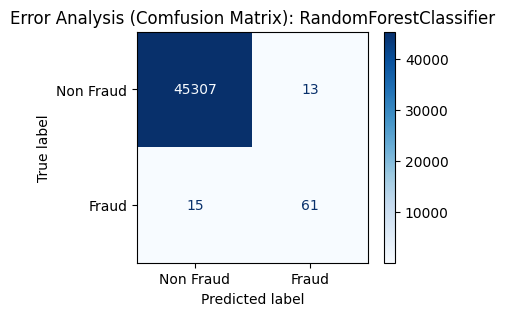

In [53]:
_, table_3 = train_evaluate(dict(models[0:1]), over=True, over_sampling=SMOTE(sampling_strategy=.5, random_state=42), 
                            cm=True, weight=True, labels=labels, class_report=True)

Classifier name: LogisticRegression 
ROC_AUC score: 0.9

               precision    recall  f1-score   support

   Non Fraud       1.00      0.99      1.00     45320
       Fraud       0.17      0.82      0.29        76

    accuracy                           0.99     45396
   macro avg       0.59      0.90      0.64     45396
weighted avg       1.00      0.99      1.00     45396
 




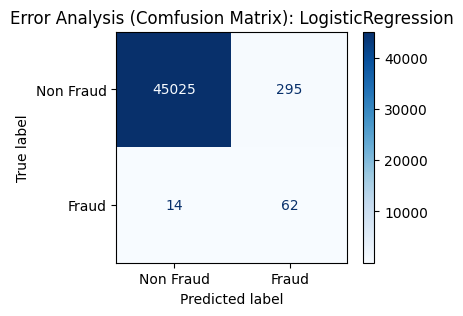

In [54]:
_, table_4 = train_evaluate(dict(models[1:2]), over=True, over_sampling=SMOTE(sampling_strategy=.5,random_state=42), 
                            cm=True,under=True, labels=labels, class_report=True)

Classifier name: XGBClassifier 
ROC_AUC score: 0.91

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.81      0.82      0.81        76

    accuracy                           1.00     45396
   macro avg       0.90      0.91      0.91     45396
weighted avg       1.00      1.00      1.00     45396
 




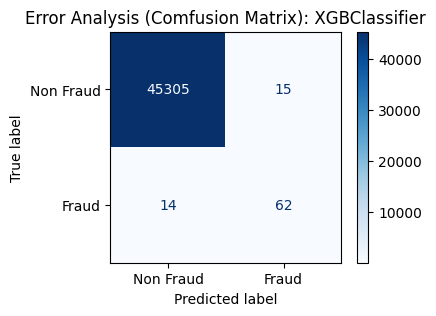

In [55]:
_, table_5 = train_evaluate(dict(models[2:3]), over=True, over_sampling=SMOTE(sampling_strategy=.5, random_state=42), 
                            cm=True, weight=True, labels=labels, class_report=True)

Classifier name: LGBMClassifier 
ROC_AUC score: 0.91

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.88      0.83      0.85        76

    accuracy                           1.00     45396
   macro avg       0.94      0.91      0.93     45396
weighted avg       1.00      1.00      1.00     45396
 




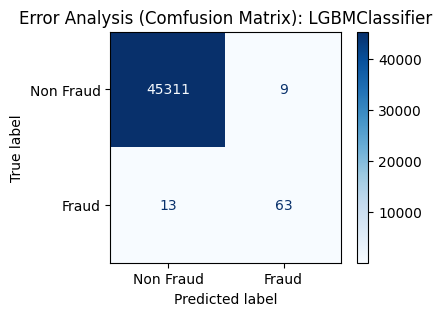

In [56]:
LGBM, table_6 = train_evaluate(dict(models[3:4]), over=True, over_sampling=SMOTE(sampling_strategy=.5, random_state=42),
                               cm=True, labels=labels, weight=True, class_report=True)

## Feature Selection

Feature selection is a process of selecting a subset of relevant features from a larger set of available features in a dataset. It aims to improve model performance by reducing dimensionality, eliminating irrelevant or redundant features, and enhancing model interpretability. 

In this section, we will be utilizing the LGBM model to select the best subset of features that significantly enhances the overall performance of our machine learning task. The primary reason for choosing the LGBMClassifier is its faster computational speed compared to other models other than LogisticRegression.

By employing the LGBM model, we can efficiently analyze the importance of each feature and identify the subset that contributes the most to improving the f1_score, which is our primary metric of evaluation. The faster execution time of LGBMClassifier enables us to explore feature combinations and efficiently evaluate their impact on model performance.

In [57]:
np.random.seed(42)

In [58]:
def get_best_features(model, over=True, under=False, strategy=.5, early_stopping=5):
    best_score = 0
    best_k = 0
    best_features = []

    consecutive_no_improvement = 0  # Track consecutive iterations without improvement

    for i, k in enumerate(range(15, X_train.shape[1] + 1), start=1):
        pipeline_steps = create_pipeline(over=over, under=under, over_sampling=SMOTE(sampling_strategy=strategy, random_state=42))

        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        pipeline_steps.append(('selector', selector))
        pipeline_steps.append(('classifier', model)) 
        pipeline = imbPipeline(steps=pipeline_steps)
        pipeline.fit(X_train, y_train)
        # pipe_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1).mean()
        y_preds = pipeline.predict(X_val)
        score = f1_score(y_val, y_preds, average='macro')
        
        if score > best_score:
            best_score = score
            best_k = k
            best_features = X_train.columns[pipeline['selector'].get_support(indices=True)]
            consecutive_no_improvement = 0  # Reset consecutive_no_improvement counter
        else:
            consecutive_no_improvement += 1
        
        if consecutive_no_improvement >= early_stopping:
            print(f"No improvement in the last {early_stopping} iterations. Stopping early.")
            break
        
        print(f"Iteration {i}: k={k}, f1_score = {score}")

    return best_k, best_features

In [59]:
best_k, best_features = get_best_features(classifiers['LGBMClassifier'], strategy=.5)

Iteration 1: k=15, f1_score = 0.8998289881615675
Iteration 2: k=16, f1_score = 0.8998289881615675
Iteration 3: k=17, f1_score = 0.9024319090957807
Iteration 4: k=18, f1_score = 0.8919748219017525
Iteration 5: k=19, f1_score = 0.9198676110412392
Iteration 6: k=20, f1_score = 0.9187865328812329
Iteration 7: k=21, f1_score = 0.9198676110412392
Iteration 8: k=22, f1_score = 0.9198676110412392
Iteration 9: k=23, f1_score = 0.9284555920663813
Iteration 10: k=24, f1_score = 0.9143302596738979
Iteration 11: k=25, f1_score = 0.9226919205938602
Iteration 12: k=26, f1_score = 0.9226919205938602
Iteration 13: k=27, f1_score = 0.9226919205938602
No improvement in the last 5 iterations. Stopping early.


In [60]:
best_features

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V21', 'V23', 'V25', 'V26',
       'V27', 'V28'],
      dtype='object')

Now that we have identified the best subset of features that significantly improve the performance of the LGBM model, we can leverage this knowledge to enhance the performance of other models as well. To achieve this, we can generalize the feature selection process by passing the best k features to the `k` argument of the train_evaluate function. In addition, we will set  the `selector` argument to True in the constructor of the train_evaluate function to ensure that the models are trained and evaluated only on the selected subset of features. By extrapolating the feature selection process to all models, we can harness the power of feature subset optimization and create more efficient and accurate models. This approach reduces the dimensionality of the data and focuses on the most informative features, which can enhance model interpretability, reduce overfitting, and improve generalization to unseen data.

Classifier name: RandomForestClassifier 
ROC_AUC score: 0.9

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.88      0.80      0.84        76

    accuracy                           1.00     45396
   macro avg       0.94      0.90      0.92     45396
weighted avg       1.00      1.00      1.00     45396
 




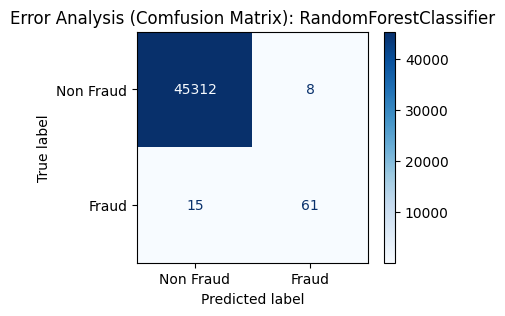

In [61]:
RF, RF_thresh, RF_table = train_evaluate(dict(models[0:1]), over=True, over_sampling=SMOTE(sampling_strategy=.5, k_neighbors=7, random_state=42), 
                               cm=True, weight=True, labels=labels, thresh=True, selector=True, k=best_k, class_report=True)

The max_iter was reached which means the coef_ did not converge


Classifier name: LogisticRegression 
ROC_AUC score: 0.78

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.81      0.55      0.66        76

    accuracy                           1.00     45396
   macro avg       0.90      0.78      0.83     45396
weighted avg       1.00      1.00      1.00     45396
 




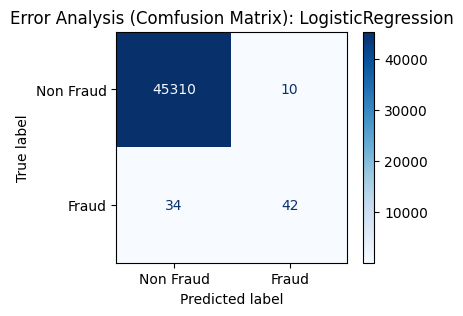

In [62]:
LR, LR_thresh, LR_table = train_evaluate(dict(models[1:2]), over_sampling=SMOTE(sampling_strategy=.5, random_state=42), selector=True, 
                                         thresh=True, k=best_k, cm=True, weight=True, labels=labels, class_report=True)

Classifier name: XGBClassifier 
ROC_AUC score: 0.91

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.90      0.82      0.86        76

    accuracy                           1.00     45396
   macro avg       0.95      0.91      0.93     45396
weighted avg       1.00      1.00      1.00     45396
 




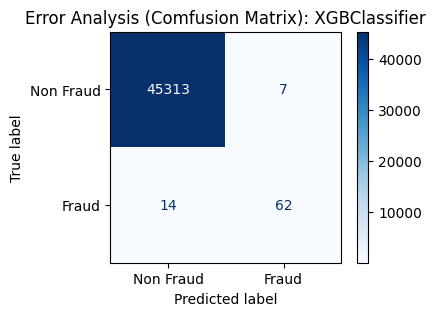

In [63]:
XGB, XGB_thresh, XGB_table = train_evaluate(dict(models[2:3]), over=True, cm=True, weight=True, labels=labels, class_report=True, thresh=True,
                                            over_sampling=SMOTE(sampling_strategy=.5, k_neighbors=6, random_state=42), selector=True, k=best_k)

Classifier name: LGBMClassifier 
ROC_AUC score: 0.91

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     45320
       Fraud       0.90      0.83      0.86        76

    accuracy                           1.00     45396
   macro avg       0.95      0.91      0.93     45396
weighted avg       1.00      1.00      1.00     45396
 




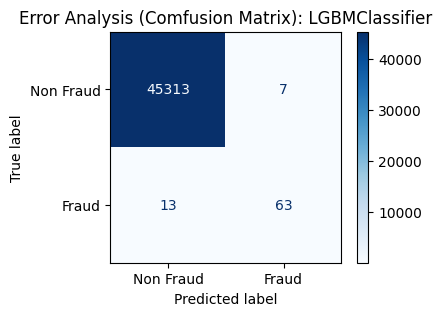

In [64]:
LGBM, LGBM_thresh, LGBM_table = train_evaluate(dict(models[3:4]), over_sampling=SMOTE(sampling_strategy=.5, random_state=42), selector=True,
                                               k=best_k, thresh=True, cm=True, over=True, weight=True, labels=labels, class_report=True)

In [65]:
clfs_metrics = pd.concat([RF_table, LR_table, XGB_table, LGBM_table], axis=0, ignore_index=True)
clfs_metrics              

,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.94,0.90,0.92,0.90,45396
1,LogisticRegression,0.90,0.78,0.83,0.78,45396
2,XGBClassifier,0.95,0.91,0.93,0.91,45396
3,LGBMClassifier,0.95,0.91,0.93,0.91,45396


In [66]:
RF_thresh, XGB_thresh, LGBM_thresh

(0.7000000000000001, 0.9, 0.6)

### Evaluation on the Test set

In [67]:
def test_evaluate(model, best_threshold, test_data, labels=labels, class_report=False, cm=False):
    
    # creates an empty dataframe with the metrics of interest as the column names
    results_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'F1-score', 'AUC_ROC', 'Support'])
    
    X_test, y_test = test_data.drop('Class', axis=1), test_data['Class']
    
    if isinstance(model, Pipeline):
        model_name = model.steps[-1][0]  # Get the name of the last step in the pipeline
        y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
    else:
        model_name = model.__class__.__name__  # Get the name of the model
        y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
    
    y_preds = (y_pred_probs >= best_threshold).astype(int)  # Apply best threshold to get binary predictions

    # compute model's classification metrics
    report, clf_report, auc_report = get_clf_report(y_test, y_preds, labels)

    if class_report:
        print(f'Classifier name: {model_name} \nROC_AUC score: {round(auc_report, 2)}\n\n', report, '\n\n')

    if cm:
        plot_confusion_matrix(y_test, y_preds, labels, model_name)
        print('\n\n')
        
    macro_report = {
                'precision': round(clf_report['macro avg']['precision'], 2),
                'recall': round(clf_report['macro avg']['recall'], 2),
                'f1-score': round(clf_report['macro avg']['f1-score'], 2),
                'support': clf_report['macro avg']['support']
            }

    # Add AUC-ROC score to dataframe
    clf_report['auc-roc'] = {'precision': np.nan, 'recall': np.nan, 'f1-score': np.nan, 'support': np.nan,
                             '': auc_report}

    # Append dataframe to results dataframe
    results_df = pd.concat([results_df, pd.DataFrame({'Classifier': [model_name],
                                                  'Precision': [macro_report['precision']],
                                                  'Recall': [macro_report['recall']],
                                                  'F1-score': [macro_report['f1-score']],
                                                  'AUC_ROC': [auc_report],
                                                  'Support': [macro_report['support']]})], axis=0, ignore_index=True)
    
    return results_df

Classifier name: RandomForestClassifier 
ROC_AUC score: 0.87

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56651
       Fraud       0.92      0.75      0.83        95

    accuracy                           1.00     56746
   macro avg       0.96      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746
 




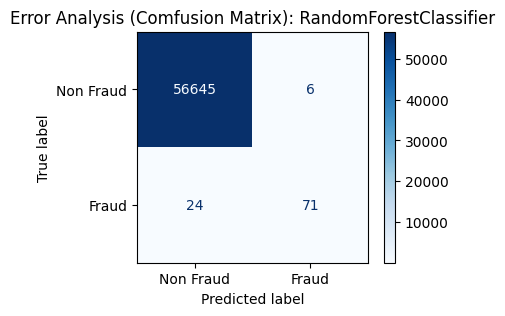

In [68]:
RF_test = test_evaluate(RF, RF_thresh, test, class_report=True, cm=True)

Classifier name: LogisticRegression 
ROC_AUC score: 0.74

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56651
       Fraud       0.85      0.47      0.61        95

    accuracy                           1.00     56746
   macro avg       0.92      0.74      0.80     56746
weighted avg       1.00      1.00      1.00     56746
 




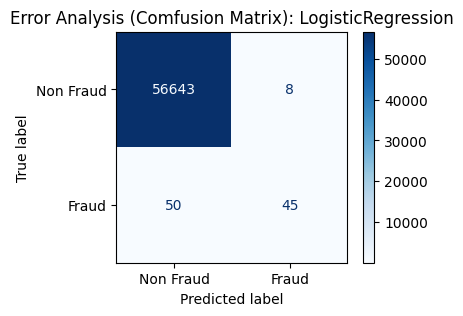

In [69]:
LR_test = test_evaluate(LR, LR_thresh, test, class_report=True, cm=True)

Classifier name: XGBClassifier 
ROC_AUC score: 0.87

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56651
       Fraud       0.91      0.75      0.82        95

    accuracy                           1.00     56746
   macro avg       0.95      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746
 




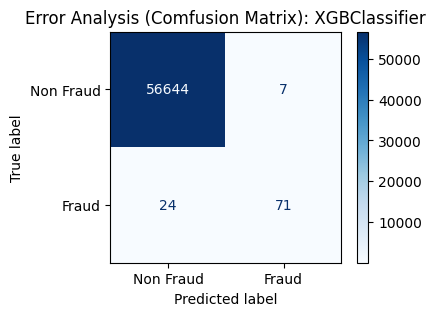

In [70]:
XGB_test = test_evaluate(XGB, XGB_thresh, test, class_report=True, cm=True)

Classifier name: LGBMClassifier 
ROC_AUC score: 0.89

               precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56651
       Fraud       0.89      0.79      0.84        95

    accuracy                           1.00     56746
   macro avg       0.95      0.89      0.92     56746
weighted avg       1.00      1.00      1.00     56746
 




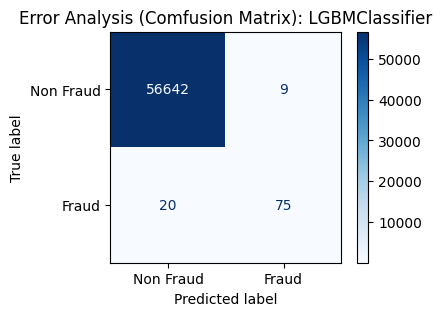

In [71]:
LGBM_test = test_evaluate(LGBM, LGBM_thresh, test, class_report=True, cm=True)

In [72]:
clfs_test_df = pd.concat([RF_test, LR_test, XGB_test, LGBM_test], axis=0, ignore_index=True)
clfs_test_df

,Classifier,Precision,Recall,F1-score,AUC_ROC,Support
0,RandomForestClassifier,0.96,0.87,0.91,0.87,56746
1,LogisticRegression,0.92,0.74,0.80,0.74,56746
2,XGBClassifier,0.95,0.87,0.91,0.87,56746
3,LGBMClassifier,0.95,0.89,0.92,0.89,56746


## Model Interpretability

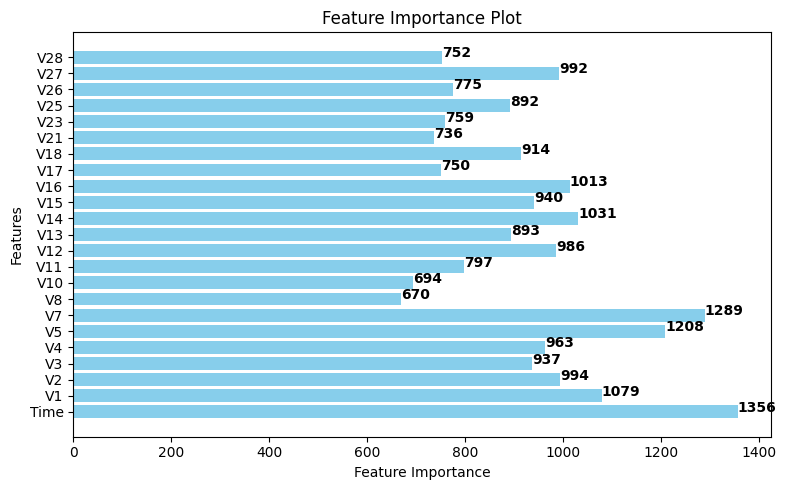

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


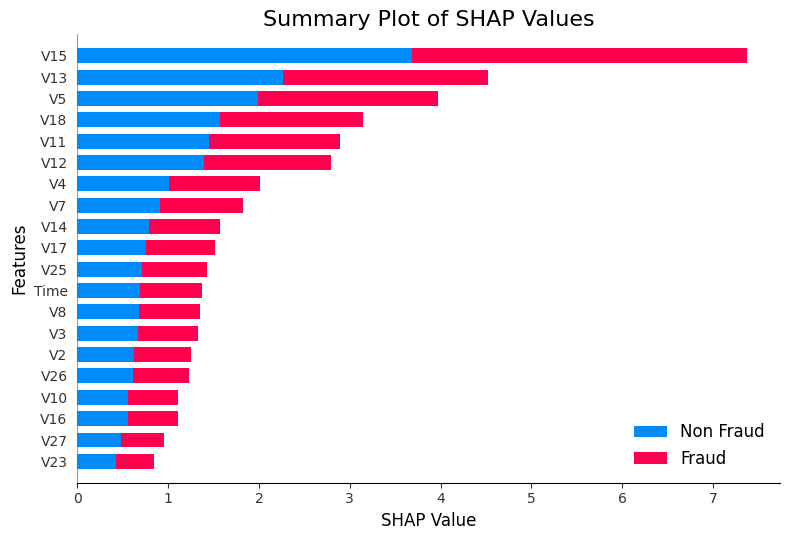

In [73]:
# Calculate feature importance
feature_importance = LGBM.steps[-1][1].feature_importances_

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(range(len(feature_importance)), feature_importance, align='center', color='skyblue')
plt.yticks(range(len(feature_importance)), best_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')

# Annotate the bars
for i, v in enumerate(feature_importance):
    plt.text(v, i, str(round(v, 2)), color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# split the testset into X_test and y_test
X_test, y_test = test.drop('Class', axis=1), test['Class']

# compute SHAP values
explainer = shap.TreeExplainer(LGBM.steps[-1][1])
shap_values = explainer.shap_values(X_test[best_features])

# Plot SHAP summary plot
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test[best_features], feature_names=best_features, class_names=labels,
                  plot_size=.2, plot_type='bar', show=False)

# Adjust plot aesthetics
plt.title('Summary Plot of SHAP Values', fontsize=16)
plt.xlabel('SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()